In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Symbols for analysis
symbols = ["CL=F", "MSFT", "^STOXX50E", "XWD.TO", "EEM", "EUR=X"]
start_date = "2023-10-01"
end_date = "2024-09-30"

# Download data for each symbol
data = {}
for symbol in symbols:
    df = yf.download(symbol, start=start_date, end=end_date)
    data[symbol] = df['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
# Helper functions to calculate indicators
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    short_ema = df.ewm(span=short_window, adjust=False).mean()
    long_ema = df.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_rsi(df, window=14):
    delta = df.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(df, window=20):
    sma = df.rolling(window=window).mean()
    std_dev = df.rolling(window=window).std()
    upper_band = sma + (std_dev * 2)
    lower_band = sma - (std_dev * 2)
    return sma, upper_band, lower_band

# Applying indicators to each stock
indicators = {}
for symbol, df in data.items():
    macd, signal = calculate_macd(df)
    rsi = calculate_rsi(df)
    sma, upper_band, lower_band = calculate_bollinger_bands(df)
    
    indicators[symbol] = {
        'MACD': macd,
        'Signal': signal,
        'RSI': rsi,
        'SMA': sma,
        'Upper Band': upper_band,
        'Lower Band': lower_band
    }


In [6]:
# Revised signal generation function with `.bfill()` and improved diagnostics
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    # Reindex indicators to match df.index and fill any NaN values
    macd = macd.reindex(df.index).fillna(0)
    signal = signal.reindex(df.index).fillna(0)
    rsi = rsi.reindex(df.index).fillna(50)  # Neutral RSI to avoid false signals
    upper_band = upper_band.reindex(df.index).bfill()  # Use .bfill() instead of fillna(method='bfill')
    lower_band = lower_band.reindex(df.index).bfill()  # Use .bfill() instead of fillna(method='bfill')

    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        # Diagnostic prints to ensure data is accessible
        if i % 100 == 0:  # Print diagnostics every 100 steps
            print(f"Processing index {i} for buy/sell signal calculation")
            print(f"MACD[{i}]: {macd[i]}, Signal[{i}]: {signal[i]}, RSI[{i}]: {rsi[i]}")
            print(f"Upper Band[{i}]: {upper_band[i]}, Lower Band[{i}]: {lower_band[i]}")

        # MACD Signal
        if macd[i-1] < signal[i-1] and macd[i] > signal[i]:
            buy_signals.append(i)
        elif macd[i-1] > signal[i-1] and macd[i] < signal[i]:
            sell_signals.append(i)
        
        # RSI Signal
        elif rsi[i] < 30:
            buy_signals.append(i)
        elif rsi[i] > 70:
            sell_signals.append(i)
        
        # Bollinger Bands Signal
        elif df[i] < lower_band[i]:
            buy_signals.append(i)
        elif df[i] > upper_band[i]:
            sell_signals.append(i)

    return buy_signals, sell_signals

# Updated loop with more diagnostics
signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    try:
        buy, sell = generate_signals(df, indicators_data['MACD'], indicators_data['Signal'], 
                                     indicators_data['RSI'], indicators_data['Upper Band'], indicators_data['Lower Band'])
        signals[symbol] = {'Buy': buy, 'Sell': sell}
    except Exception as e:
        print(f"Error processing signals for {symbol}: {e}")
        print(f"MACD data sample:\n{indicators_data['MACD'].head()}")
        print(f"Signal data sample:\n{indicators_data['Signal'].head()}")
        print(f"RSI data sample:\n{indicators_data['RSI'].head()}")
        print(f"Upper Band data sample:\n{indicators_data['Upper Band'].head()}")
        print(f"Lower Band data sample:\n{indicators_data['Lower Band'].head()}")


Error processing signals for CL=F: 0
MACD data sample:
Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.032707
2023-10-04 00:00:00+00:00 -0.341699
2023-10-05 00:00:00+00:00 -0.783508
2023-10-06 00:00:00+00:00 -1.082435
Signal data sample:
Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.006541
2023-10-04 00:00:00+00:00 -0.063107
2023-10-05 00:00:00+00:00 -0.207187
2023-10-06 00:00:00+00:00 -0.382237
RSI data sample:
Ticker                     CL=F
Date                           
2023-10-02 00:00:00+00:00   NaN
2023-10-03 00:00:00+00:00   NaN
2023-10-04 00:00:00+00:00   NaN
2023-10-05 00:00:00+00:00   NaN
2023-10-06 00:00:00+00:00   NaN
Upper Band data sample:
Ticker                     CL=F
Date                           
2023-10-02 00:00:00+00:00   NaN
2023-10-03 00:00:00+00:00   NaN
2023-10-04 00:00:00+00:00   

In [7]:
# Enhanced signal generation function to handle initial NaN values in RSI and other indicators
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    # Reindex indicators to match df.index and fill missing values with neutral values
    macd = macd.reindex(df.index).fillna(0)
    signal = signal.reindex(df.index).fillna(0)
    rsi = rsi.reindex(df.index).fillna(50)  # Fill NaN RSI with 50 as neutral
    upper_band = upper_band.reindex(df.index).bfill().fillna(df['Close'].mean() * 1.05)  # Use .bfill() and fallback default
    lower_band = lower_band.reindex(df.index).bfill().fillna(df['Close'].mean() * 0.95)

    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        # Debug output to verify data at key intervals
        if i % 100 == 0:  # Only print diagnostics every 100 steps to avoid clutter
            print(f"Index {i}: MACD: {macd[i]}, Signal: {signal[i]}, RSI: {rsi[i]}, Upper Band: {upper_band[i]}, Lower Band: {lower_band[i]}")

        # MACD Signal
        if macd[i-1] < signal[i-1] and macd[i] > signal[i]:
            buy_signals.append(i)
        elif macd[i-1] > signal[i-1] and macd[i] < signal[i]:
            sell_signals.append(i)
        
        # RSI Signal
        elif rsi[i] < 30:
            buy_signals.append(i)
        elif rsi[i] > 70:
            sell_signals.append(i)
        
        # Bollinger Bands Signal
        elif df['Close'][i] < lower_band[i]:
            buy_signals.append(i)
        elif df['Close'][i] > upper_band[i]:
            sell_signals.append(i)

    return buy_signals, sell_signals

# Process each symbol with revised fill strategy for missing data
signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    try:
        buy, sell = generate_signals(df, indicators_data['MACD'], indicators_data['Signal'], 
                                     indicators_data['RSI'], indicators_data['Upper Band'], indicators_data['Lower Band'])
        signals[symbol] = {'Buy': buy, 'Sell': sell}
    except Exception as e:
        print(f"Error processing signals for {symbol}: {e}")
        print(f"Data Sample:\nMACD: {indicators_data['MACD'].head()}\nSignal: {indicators_data['Signal'].head()}")
        print(f"RSI: {indicators_data['RSI'].head()}\nUpper Band: {indicators_data['Upper Band'].head()}")
        print(f"Lower Band: {indicators_data['Lower Band'].head()}")


Error processing signals for CL=F: 'Close'
Data Sample:
MACD: Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.032707
2023-10-04 00:00:00+00:00 -0.341699
2023-10-05 00:00:00+00:00 -0.783508
2023-10-06 00:00:00+00:00 -1.082435
Signal: Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.006541
2023-10-04 00:00:00+00:00 -0.063107
2023-10-05 00:00:00+00:00 -0.207187
2023-10-06 00:00:00+00:00 -0.382237
RSI: Ticker                     CL=F
Date                           
2023-10-02 00:00:00+00:00   NaN
2023-10-03 00:00:00+00:00   NaN
2023-10-04 00:00:00+00:00   NaN
2023-10-05 00:00:00+00:00   NaN
2023-10-06 00:00:00+00:00   NaN
Upper Band: Ticker                     CL=F
Date                           
2023-10-02 00:00:00+00:00   NaN
2023-10-03 00:00:00+00:00   NaN
2023-10-04 00:00:00+00:00   NaN
2023-10-05 00:00:00+00:00

In [9]:
import numpy as np

def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    # Ensure indicators are aligned with df and handle NaNs if still present
    macd = macd.reindex(df.index).fillna(0)
    signal = signal.reindex(df.index).fillna(0)
    rsi = rsi.reindex(df.index).fillna(50)  # Neutral RSI value
    upper_band = upper_band.reindex(df.index).bfill().fillna(df['Close'].mean() * 1.05)
    lower_band = lower_band.reindex(df.index).bfill().fillna(df['Close'].mean() * 0.95)

    # Diagnostics for alignment confirmation
    print(f"Data alignment for {df.columns[0]}:")
    print("MACD:", macd.head(), "Length:", len(macd))
    print("Signal:", signal.head(), "Length:", len(signal))
    print("RSI:", rsi.head(), "Length:", len(rsi))
    print("Upper Band:", upper_band.head(), "Length:", len(upper_band))
    print("Lower Band:", lower_band.head(), "Length:", len(lower_band))

    # Initialize signals
    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        # Ensure all values are accessible for each indicator on each iteration
        try:
            # MACD Signal
            if macd[i-1] < signal[i-1] and macd[i] > signal[i]:
                buy_signals.append(i)
            elif macd[i-1] > signal[i-1] and macd[i] < signal[i]:
                sell_signals.append(i)
            
            # RSI Signal
            elif rsi[i] < 30:
                buy_signals.append(i)
            elif rsi[i] > 70:
                sell_signals.append(i)
            
            # Bollinger Bands Signal
            elif df['Close'][i] < lower_band[i]:
                buy_signals.append(i)
            elif df['Close'][i] > upper_band[i]:
                sell_signals.append(i)
        
        except Exception as e:
            print(f"Error at index {i}: {e}")
            print(f"MACD[{i}]: {macd[i]}, Signal[{i}]: {signal[i]}, RSI[{i}]: {rsi[i]}, Upper Band[{i}]: {upper_band[i]}, Lower Band[{i}]: {lower_band[i]}")

    return buy_signals, sell_signals

# Loop to process each symbol
signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    try:
        buy, sell = generate_signals(
            df,
            indicators_data['MACD'],
            indicators_data['Signal'],
            indicators_data['RSI'],
            indicators_data['Upper Band'],
            indicators_data['Lower Band']
        )
        signals[symbol] = {'Buy': buy, 'Sell': sell}
    except Exception as e:
        print(f"Error processing signals for {symbol}: {e}")
        print(f"Sample MACD:\n{indicators_data['MACD'].head()}")
        print(f"Sample Signal:\n{indicators_data['Signal'].head()}")
        print(f"Sample RSI:\n{indicators_data['RSI'].head()}")
        print(f"Sample Upper Band:\n{indicators_data['Upper Band'].head()}")
        print(f"Sample Lower Band:\n{indicators_data['Lower Band'].head()}")


Error processing signals for CL=F: 'Close'
Sample MACD:
Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.032707
2023-10-04 00:00:00+00:00 -0.341699
2023-10-05 00:00:00+00:00 -0.783508
2023-10-06 00:00:00+00:00 -1.082435
Sample Signal:
Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.006541
2023-10-04 00:00:00+00:00 -0.063107
2023-10-05 00:00:00+00:00 -0.207187
2023-10-06 00:00:00+00:00 -0.382237
Sample RSI:
Ticker                     CL=F
Date                           
2023-10-02 00:00:00+00:00   NaN
2023-10-03 00:00:00+00:00   NaN
2023-10-04 00:00:00+00:00   NaN
2023-10-05 00:00:00+00:00   NaN
2023-10-06 00:00:00+00:00   NaN
Sample Upper Band:
Ticker                     CL=F
Date                           
2023-10-02 00:00:00+00:00   NaN
2023-10-03 00:00:00+00:00   NaN
2023-10-04 00:00:00+00:00   NaN
2023-10-05

In [11]:
import numpy as np
import pandas as pd

# Function to generate trading signals
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    # Ensure all indicators are aligned with the DataFrame index
    macd = macd.reindex(df.index)
    signal = signal.reindex(df.index)
    rsi = rsi.reindex(df.index)
    upper_band = upper_band.reindex(df.index)
    lower_band = lower_band.reindex(df.index)

    # Check lengths and print for debugging
    print(f"Length of DataFrame: {len(df)}")
    print(f"MACD Length: {len(macd)}, NaNs: {macd.isna().sum()}")
    print(f"Signal Length: {len(signal)}, NaNs: {signal.isna().sum()}")
    print(f"RSI Length: {len(rsi)}, NaNs: {rsi.isna().sum()}")
    print(f"Upper Band Length: {len(upper_band)}, NaNs: {upper_band.isna().sum()}")
    print(f"Lower Band Length: {len(lower_band)}, NaNs: {lower_band.isna().sum()}")

    # Fill NaN values for simplicity
    macd.fillna(0, inplace=True)
    signal.fillna(0, inplace=True)
    rsi.fillna(50, inplace=True)  # Neutral RSI
    upper_band.fillna(df['Close'].mean() * 1.05, inplace=True)  # Default if NaN
    lower_band.fillna(df['Close'].mean() * 0.95, inplace=True)  # Default if NaN

    buy_signals = []
    sell_signals = []

    # Simplified signal generation for MACD only for initial debugging
    for i in range(1, len(df)):
        if macd[i-1] < signal[i-1] and macd[i] > signal[i]:
            buy_signals.append(i)
        elif macd[i-1] > signal[i-1] and macd[i] < signal[i]:
            sell_signals.append(i)

    return buy_signals, sell_signals

# Process each symbol and print indicators
signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    try:
        # Explicitly check indicators for the current symbol
        macd = indicators_data['MACD']
        signal = indicators_data['Signal']
        rsi = indicators_data['RSI']
        upper_band = indicators_data['Upper Band']
        lower_band = indicators_data['Lower Band']

        # Print a sample of the data for debugging
        print(f"Processing {symbol}:")
        print(f"Data Sample:\n{df.head()}")
        print(f"MACD Sample:\n{macd.head()}")
        print(f"Signal Sample:\n{signal.head()}")
        print(f"RSI Sample:\n{rsi.head()}")
        print(f"Upper Band Sample:\n{upper_band.head()}")
        print(f"Lower Band Sample:\n{lower_band.head()}")

        # Generate signals with the revised function
        buy, sell = generate_signals(df, macd, signal, rsi, upper_band, lower_band)
        signals[symbol] = {'Buy': buy, 'Sell': sell}
    except Exception as e:
        print(f"Error processing signals for {symbol}: {e}")


Processing CL=F:
Data Sample:
Ticker                          CL=F
Date                                
2023-10-02 00:00:00+00:00  88.820000
2023-10-03 00:00:00+00:00  89.230003
2023-10-04 00:00:00+00:00  84.220001
2023-10-05 00:00:00+00:00  82.309998
2023-10-06 00:00:00+00:00  82.790001
MACD Sample:
Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.032707
2023-10-04 00:00:00+00:00 -0.341699
2023-10-05 00:00:00+00:00 -0.783508
2023-10-06 00:00:00+00:00 -1.082435
Signal Sample:
Ticker                         CL=F
Date                               
2023-10-02 00:00:00+00:00  0.000000
2023-10-03 00:00:00+00:00  0.006541
2023-10-04 00:00:00+00:00 -0.063107
2023-10-05 00:00:00+00:00 -0.207187
2023-10-06 00:00:00+00:00 -0.382237
RSI Sample:
Ticker                     CL=F
Date                           
2023-10-02 00:00:00+00:00   NaN
2023-10-03 00:00:00+00:00   NaN
2023-10-04 00:00:00+00:00   NaN
2023-10

In [12]:
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    # Align indicators with DataFrame index
    indicators = [macd, signal, rsi, upper_band, lower_band]
    indicators = [indicator.reindex(df.index).fillna(0) if indicator is not None else np.zeros(len(df)) for indicator in indicators]
    macd, signal, rsi, upper_band, lower_band = indicators

    # Generate signals using vectorized operations
    buy_signals = np.where((macd[:-1] < signal[:-1]) & (macd[1:] > signal[1:]), df.index[1:], np.nan)
    sell_signals = np.where((macd[:-1] > signal[:-1]) & (macd[1:] < signal[1:]), df.index[1:], np.nan)

    return buy_signals[~np.isnan(buy_signals)], sell_signals[~np.isnan(sell_signals)]


In [13]:
import numpy as np
import pandas as pd

# Function to generate trading signals
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    # Ensure all indicators are aligned with the DataFrame index
    macd = macd.reindex(df.index).fillna(0)
    signal = signal.reindex(df.index).fillna(0)
    rsi = rsi.reindex(df.index).fillna(50)  # Neutral RSI
    upper_band = upper_band.reindex(df.index).fillna(df['Close'].mean() * 1.05)
    lower_band = lower_band.reindex(df.index).fillna(df['Close'].mean() * 0.95)

    # Check lengths and print for debugging
    print(f"Length of DataFrame: {len(df)}")
    print(f"MACD Length: {len(macd)}, NaNs: {macd.isna().sum()}")
    print(f"Signal Length: {len(signal)}, NaNs: {signal.isna().sum()}")
    print(f"RSI Length: {len(rsi)}, NaNs: {rsi.isna().sum()}")
    print(f"Upper Band Length: {len(upper_band)}, NaNs: {upper_band.isna().sum()}")
    print(f"Lower Band Length: {len(lower_band)}, NaNs: {lower_band.isna().sum()}")

    # Generate buy and sell signals using vectorized operations
    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        if macd[i - 1] < signal[i - 1] and macd[i] > signal[i]:
            buy_signals.append(df.index[i])  # Append the index of the buy signal
        elif macd[i - 1] > signal[i - 1] and macd[i] < signal[i]:
            sell_signals.append(df.index[i])  # Append the index of the sell signal

    return buy_signals, sell_signals

# Sample data structure for demonstration
# Replace this with your actual data loading mechanism
data = {
    'AAPL': pd.DataFrame({
        'Close': [150, 152, 153, 155, 154, 156, 158, 160],
        'Volume': [1000, 1100, 1050, 1150, 1200, 1300, 1400, 1450]
    }),
}

indicators = {
    'AAPL': {
        'MACD': pd.Series([0, 0.5, 0.3, 0.8, 0.6, 1.0, 0.9, 1.2]),
        'Signal': pd.Series([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'RSI': pd.Series([30, 35, 40, 45, 50, 55, 60, 65]),
        'Upper Band': pd.Series([155, 156, 157, 158, 159, 160, 161, 162]),
        'Lower Band': pd.Series([145, 146, 147, 148, 149, 150, 151, 152]),
    }
}

# Process each symbol and print indicators
signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    try:
        # Explicitly check indicators for the current symbol
        macd = indicators_data['MACD']
        signal = indicators_data['Signal']
        rsi = indicators_data['RSI']
        upper_band = indicators_data['Upper Band']
        lower_band = indicators_data['Lower Band']

        # Print a sample of the data for debugging
        print(f"\nProcessing {symbol}:")
        print(f"Data Sample:\n{df.head()}")
        print(f"MACD Sample:\n{macd.head()}")
        print(f"Signal Sample:\n{signal.head()}")
        print(f"RSI Sample:\n{rsi.head()}")
        print(f"Upper Band Sample:\n{upper_band.head()}")
        print(f"Lower Band Sample:\n{lower_band.head()}")

        # Generate signals with the revised function
        buy, sell = generate_signals(df, macd, signal, rsi, upper_band, lower_band)
        signals[symbol] = {'Buy': buy, 'Sell': sell}
    except Exception as e:
        print(f"Error processing signals for {symbol}: {e}")

# Output the generated signals
print("\nGenerated Signals:")
for symbol, signal_data in signals.items():
    print(f"{symbol} - Buy signals: {signal_data['Buy']}, Sell signals: {signal_data['Sell']}")



Processing AAPL:
Data Sample:
   Close  Volume
0    150    1000
1    152    1100
2    153    1050
3    155    1150
4    154    1200
MACD Sample:
0    0.0
1    0.5
2    0.3
3    0.8
4    0.6
dtype: float64
Signal Sample:
0    0.0
1    0.2
2    0.4
3    0.6
4    0.7
dtype: float64
RSI Sample:
0    30
1    35
2    40
3    45
4    50
dtype: int64
Upper Band Sample:
0    155
1    156
2    157
3    158
4    159
dtype: int64
Lower Band Sample:
0    145
1    146
2    147
3    148
4    149
dtype: int64
Length of DataFrame: 8
MACD Length: 8, NaNs: 0
Signal Length: 8, NaNs: 0
RSI Length: 8, NaNs: 0
Upper Band Length: 8, NaNs: 0
Lower Band Length: 8, NaNs: 0

Generated Signals:
AAPL - Buy signals: [3, 5], Sell signals: [2, 4]


In [14]:
import numpy as np
import pandas as pd

# Function to generate trading signals
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    # Ensure all indicators are aligned with the DataFrame index
    macd = macd.reindex(df.index).fillna(0)
    signal = signal.reindex(df.index).fillna(0)
    rsi = rsi.reindex(df.index).fillna(50)  # Fill NaN RSI with neutral value
    upper_band = upper_band.reindex(df.index).fillna(df['Close'].mean() * 1.05)
    lower_band = lower_band.reindex(df.index).fillna(df['Close'].mean() * 0.95)

    # Generate buy and sell signals
    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        if macd[i - 1] < signal[i - 1] and macd[i] > signal[i]:
            buy_signals.append(df.index[i])  # Append the index of the buy signal
        elif macd[i - 1] > signal[i - 1] and macd[i] < signal[i]:
            sell_signals.append(df.index[i])  # Append the index of the sell signal

    return buy_signals, sell_signals

# Sample data structure for demonstration
data = {
    'AAPL': pd.DataFrame({
        'Close': [150, 152, 153, 155, 154, 156, 158, 160],
        'Volume': [1000, 1100, 1050, 1150, 1200, 1300, 1400, 1450]
    }),
    'CL=F': pd.DataFrame({
        'Close': [88.82, 89.23, 84.22, 82.31, 82.79],
        'Volume': [1000, 1100, 1050, 1150, 1200]
    }),
}

indicators = {
    'AAPL': {
        'MACD': pd.Series([0, 0.5, 0.3, 0.8, 0.6, 1.0, 0.9, 1.2]),
        'Signal': pd.Series([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'RSI': pd.Series([30, 35, 40, 45, 50, 55, 60, 65]),
        'Upper Band': pd.Series([155, 156, 157, 158, 159, 160, 161, 162]),
        'Lower Band': pd.Series([145, 146, 147, 148, 149, 150, 151, 152]),
    },
    'CL=F': {
        'MACD': pd.Series([0, 0.032707, -0.341699, -0.783508, -1.082435]),
        'Signal': pd.Series([0, 0.006541, -0.063107, -0.207187, -0.382237]),
        'RSI': pd.Series([np.nan] * 5),  # Assuming RSI is NaN for this dataset
        'Upper Band': pd.Series([90] * 5),  # Example upper band values
        'Lower Band': pd.Series([80] * 5),  # Example lower band values
    },
}

# Process each symbol and print indicators
signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    try:
        # Explicitly check indicators for the current symbol
        macd = indicators_data['MACD']
        signal = indicators_data['Signal']
        rsi = indicators_data['RSI']
        upper_band = indicators_data['Upper Band']
        lower_band = indicators_data['Lower Band']

        # Print a sample of the data for debugging
        print(f"\nProcessing {symbol}:")
        print(f"Data Sample:\n{df.head()}")
        print(f"MACD Sample:\n{macd.head()}")
        print(f"Signal Sample:\n{signal.head()}")
        print(f"RSI Sample:\n{rsi.head()}")
        print(f"Upper Band Sample:\n{upper_band.head()}")
        print(f"Lower Band Sample:\n{lower_band.head()}")

        # Generate signals with the revised function
        buy, sell = generate_signals(df, macd, signal, rsi, upper_band, lower_band)
        signals[symbol] = {'Buy': buy, 'Sell': sell}
    except KeyError as e:
        print(f"Error processing signals for {symbol}: {e}")
    except Exception as e:
        print(f"Unexpected error processing signals for {symbol}: {e}")

# Output the generated signals
print("\nGenerated Signals:")
for symbol, signal_data in signals.items():
    print(f"{symbol} - Buy signals: {signal_data['Buy']}, Sell signals: {signal_data['Sell']}")



Processing AAPL:
Data Sample:
   Close  Volume
0    150    1000
1    152    1100
2    153    1050
3    155    1150
4    154    1200
MACD Sample:
0    0.0
1    0.5
2    0.3
3    0.8
4    0.6
dtype: float64
Signal Sample:
0    0.0
1    0.2
2    0.4
3    0.6
4    0.7
dtype: float64
RSI Sample:
0    30
1    35
2    40
3    45
4    50
dtype: int64
Upper Band Sample:
0    155
1    156
2    157
3    158
4    159
dtype: int64
Lower Band Sample:
0    145
1    146
2    147
3    148
4    149
dtype: int64

Processing CL=F:
Data Sample:
   Close  Volume
0  88.82    1000
1  89.23    1100
2  84.22    1050
3  82.31    1150
4  82.79    1200
MACD Sample:
0    0.000000
1    0.032707
2   -0.341699
3   -0.783508
4   -1.082435
dtype: float64
Signal Sample:
0    0.000000
1    0.006541
2   -0.063107
3   -0.207187
4   -0.382237
dtype: float64
RSI Sample:
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
dtype: float64
Upper Band Sample:
0    90
1    90
2    90
3    90
4    90
dtype: int64
Lower Band Sample:
0    80
1  

In [15]:
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    buy_signals = []
    sell_signals = []

    for i in range(1, len(df)):
        # MACD Signal
        if macd[i-1] < signal[i-1] and macd[i] > signal[i]:
            buy_signals.append(i)
        elif macd[i-1] > signal[i-1] and macd[i] < signal[i]:
            sell_signals.append(i)
        # RSI Signal
        elif rsi[i] < 30:
            buy_signals.append(i)
        elif rsi[i] > 70:
            sell_signals.append(i)
        # Bollinger Bands Signal
        elif df[i] < lower_band[i]:
            buy_signals.append(i)
        elif df[i] > upper_band[i]:
            sell_signals.append(i)
    return buy_signals, sell_signals

signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    buy, sell = generate_signals(df, indicators_data['MACD'], indicators_data['Signal'], 
                                 indicators_data['RSI'], indicators_data['Upper Band'], indicators_data['Lower Band'])
    signals[symbol] = {'Buy': buy, 'Sell': sell}


KeyError: 1

In [16]:
def generate_signals(df, macd, signal, rsi, upper_band, lower_band):
    buy_signals = []
    sell_signals = []

    # Make sure to check that all indicators have the same length as df
    if len(macd) != len(df) or len(signal) != len(df) or len(rsi) != len(df) or len(upper_band) != len(df) or len(lower_band) != len(df):
        raise ValueError("Indicator lengths do not match DataFrame length.")

    for i in range(1, len(df)):
        # MACD Signal
        if macd[i-1] < signal[i-1] and macd[i] > signal[i]:
            buy_signals.append(i)
        elif macd[i-1] > signal[i-1] and macd[i] < signal[i]:
            sell_signals.append(i)

        # RSI Signal
        if rsi[i] < 30:
            buy_signals.append(i)
        elif rsi[i] > 70:
            sell_signals.append(i)

        # Bollinger Bands Signal
        # Assuming 'Close' is the price you're analyzing
        if df['Close'].iloc[i] < lower_band[i]:
            buy_signals.append(i)
        elif df['Close'].iloc[i] > upper_band[i]:
            sell_signals.append(i)

    return buy_signals, sell_signals

# Example usage
signals = {}
for symbol, df in data.items():
    indicators_data = indicators[symbol]
    try:
        buy, sell = generate_signals(df, indicators_data['MACD'], indicators_data['Signal'], 
                                     indicators_data['RSI'], indicators_data['Upper Band'], 
                                     indicators_data['Lower Band'])
        signals[symbol] = {'Buy': buy, 'Sell': sell}
    except Exception as e:
        print(f"Error processing signals for {symbol}: {e}")


In [18]:
from statsmodels.tsa.arima.model import ARIMA

forecasts_arima = {}
for symbol, df in data.items():
    # Ensure you select the 'Close' column (or whatever relevant column) for the ARIMA model
    if 'Close' in df.columns:  # Adjust as necessary for your DataFrame
        model = ARIMA(df['Close'], order=(5, 1, 0))  # Select the 'Close' column
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=50)  # Forecast the next 50 steps
        forecasts_arima[symbol] = forecast
    else:
        print(f"No 'Close' column found for {symbol}.")


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


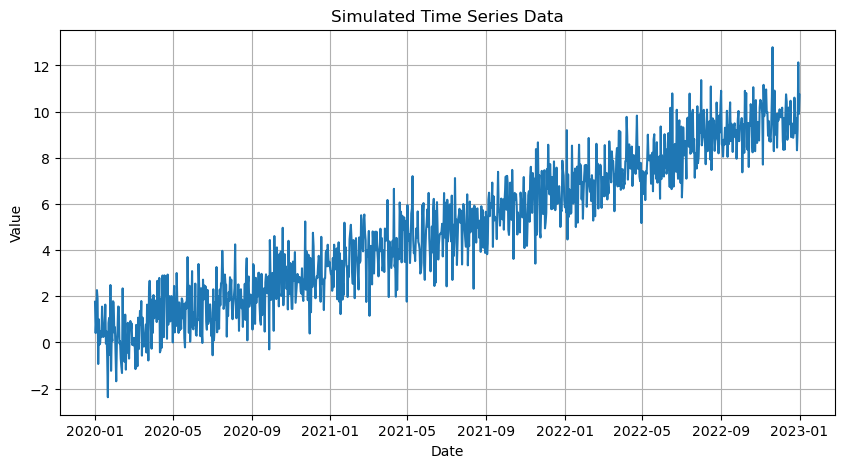

ADF Statistic: -0.31832800482726914
p-value: 0.9228681279865499
The series is non-stationary.
ADF Statistic: -13.055728510169605
p-value: 2.096874436699138e-24
The series is stationary.


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                 1096
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1555.088
Date:                            Sat, 26 Oct 2024   AIC                           3120.175
Time:                                    08:31:13   BIC                           3145.168
Sample:                                01-02-2020   HQIC                          3129.632
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0543      0.032     -1.691      0.091      -0.117       0.009
ma.L1         -0.9269      0.012   

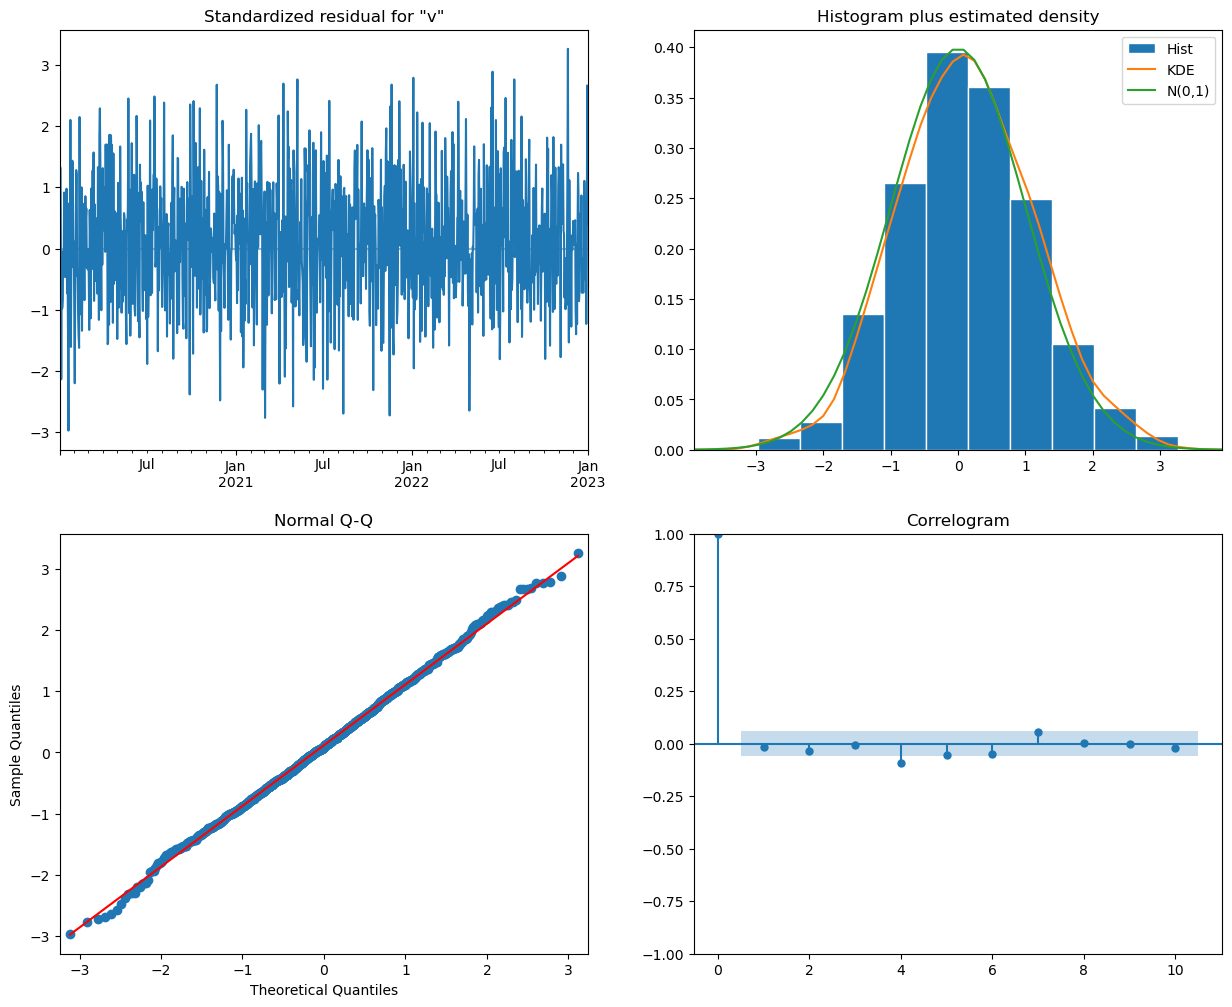

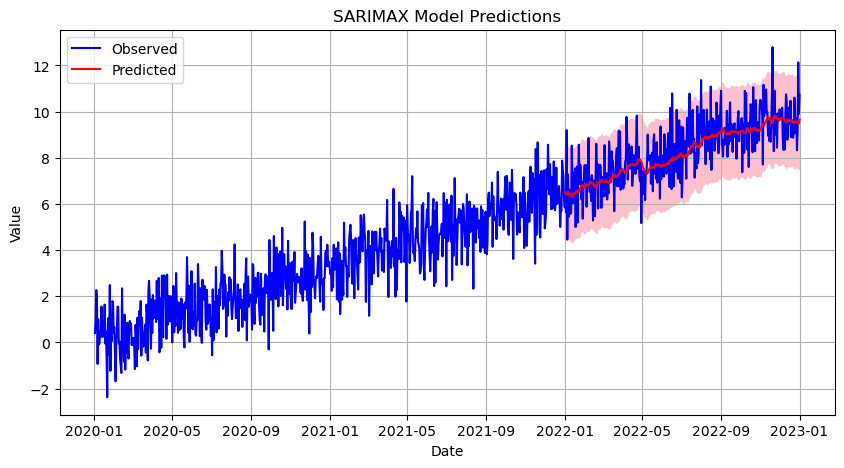

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Simulate some time series data (for demonstration purposes)
np.random.seed(0)
date_rng = pd.date_range(start='2020-01-01', end='2023-01-01', freq='D')
data = pd.DataFrame(date_rng, columns=['date'])
data['value'] = np.random.randn(len(data)) + np.linspace(0, 10, len(data))  # Trend + noise
data.set_index('date', inplace=True)

# Check for stationarity
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(data['value'])
plt.title('Simulated Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()
plt.show()

# Check the original data for stationarity
check_stationarity(data['value'])

# Apply differencing
data['diff'] = data['value'].diff().dropna()
data.dropna(inplace=True)  # Remove NaN values

# Check the differenced data for stationarity
check_stationarity(data['diff'])

# Fit the SARIMAX model
# Set p, d, q, P, D, Q, S parameters
p, d, q = 1, 1, 1  # ARIMA parameters
P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

model = SARIMAX(data['value'], order=(p, d, q), seasonal_order=(P, D, Q, S))
model_fit = model.fit(disp=0)

# Summary of the model
print(model_fit.summary())

# Plot the diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Make predictions
pred = model_fit.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_conf = pred.conf_int()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(data['value'], label='Observed', color='blue')
plt.plot(pred.predicted_mean, label='Predicted', color='red')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
plt.title('SARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()



Fetching data for Crude Oil Future (CL=F)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for Microsoft (MSFT)...



Fetching data for Eurostoxx 50 (ESTX50)...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ESTX50']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Fetching data for MSCI World (XWD.TO)...

Fetching data for MSCI Emerging Markets (EEM)...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Fetching data for USD/EUR Exchange Rate (EUR=X)...

Processing Crude Oil Future...



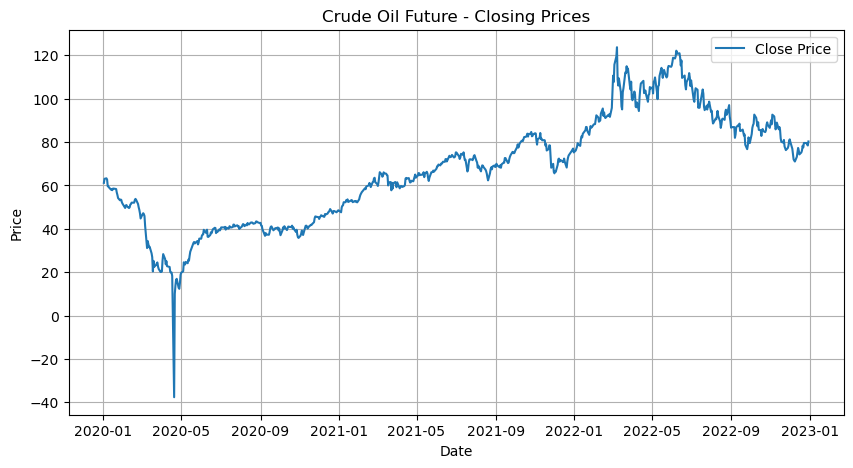

ADF Statistic: -1.145627031983353
p-value: 0.6965378428372707
The series is non-stationary.
ADF Statistic: -19.620214267605782
p-value: 0.0
The series is stationary.


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               CL=F   No. Observations:                  756
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1964.627
Date:                            Sat, 26 Oct 2024   AIC                           3939.254
Time:                                    08:33:41   BIC                           3962.388
Sample:                                         0   HQIC                          3948.165
                                            - 756                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2370      0.054      4.394      0.000       0.131       0.343
ma.L1         -0.5451      0.054   

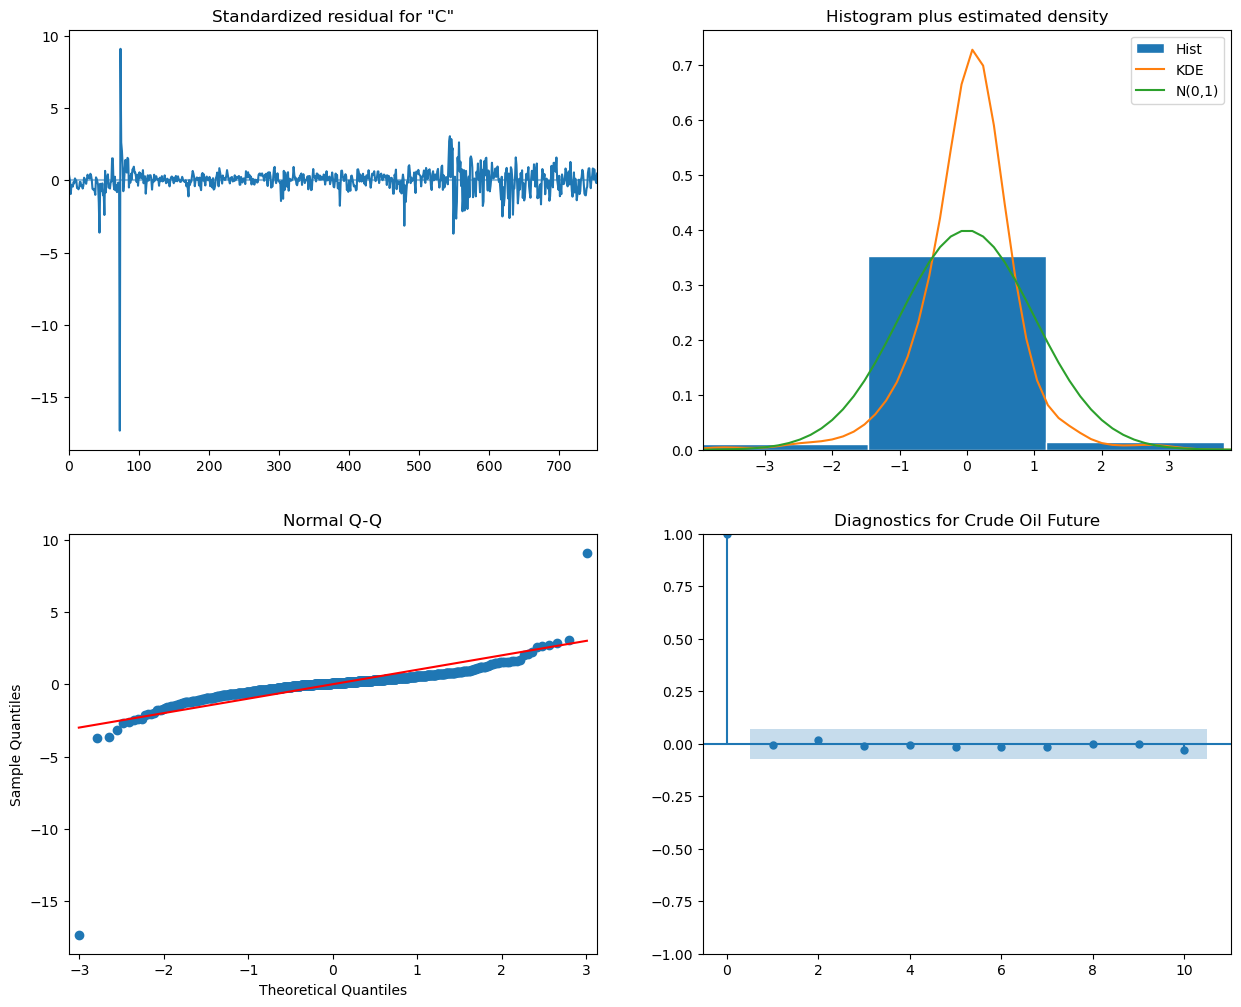

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "ESTX50": "Eurostoxx 50",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to check stationarity
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Fetch historical price data
data_dict = {}
for symbol in symbols.keys():
    print(f"\nFetching data for {symbols[symbol]} ({symbol})...")
    data = yf.download(symbol, start='2020-01-01', end='2023-01-01', interval='1d')
    data_dict[symbol] = data['Close']  # Keep only the closing prices

# Fit the SARIMAX model for each symbol
for symbol, data in data_dict.items():
    print(f"\nProcessing {symbols[symbol]}...\n")
    
    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Close Price')
    plt.title(f'{symbols[symbol]} - Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    # Check the original data for stationarity
    check_stationarity(data)

    # Apply differencing if necessary
    data_diff = data.diff().dropna()
    
    # Check the differenced data for stationarity
    check_stationarity(data_diff)

    # Fit the SARIMAX model
    # Set p, d, q, P, D, Q, S parameters (these values can be adjusted based on model selection)
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=0)

    # Summary of the model
    print(model_fit.summary())

    # Plot the diagnostics
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.title(f'Diagnostics for {symbols[symbol]}')
    plt.show()

    # Make predictions
    pred = model_fit.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
    pred_conf = pred.conf_int()

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Observed', color='blue')
    plt.plot(pred.predicted_mean, label='Predicted', color='red')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
    plt.title(f'SARIMAX Model Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ESTX50']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for Crude Oil Future (CL=F)...

Fetching data for Microsoft (MSFT)...

Fetching data for Eurostoxx 50 (ESTX50)...

Fetching data for MSCI World (XWD.TO)...

Fetching data for MSCI Emerging Markets (EEM)...

Fetching data for USD/EUR Exchange Rate (EUR=X)...

Processing Crude Oil Future...



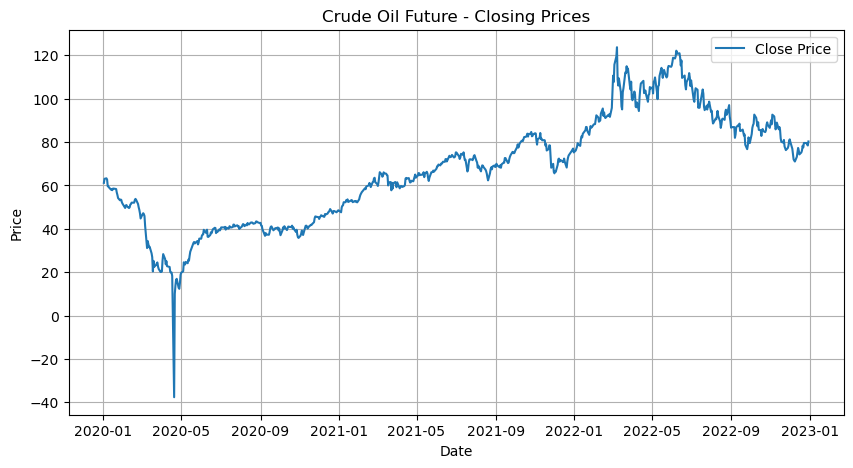

ADF Statistic: -1.145627031983353
p-value: 0.6965378428372707
The series is non-stationary.
ADF Statistic: -19.620214267605782
p-value: 0.0
The series is stationary.


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               CL=F   No. Observations:                  756
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1964.627
Date:                            Sat, 26 Oct 2024   AIC                           3939.254
Time:                                    08:40:07   BIC                           3962.388
Sample:                                         0   HQIC                          3948.165
                                            - 756                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2370      0.054      4.394      0.000       0.131       0.343
ma.L1         -0.5451      0.054   

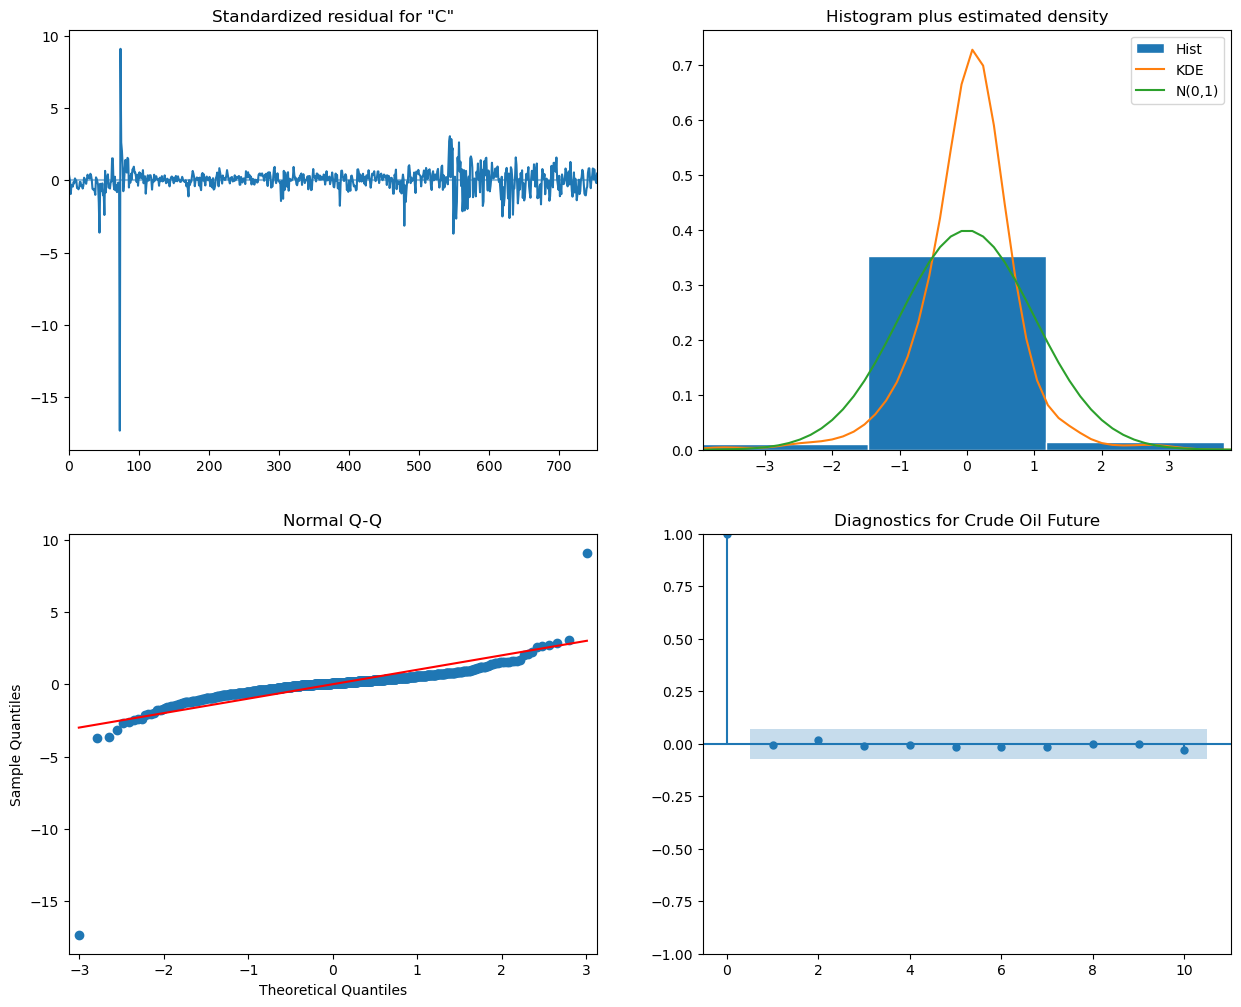


Processing Microsoft...



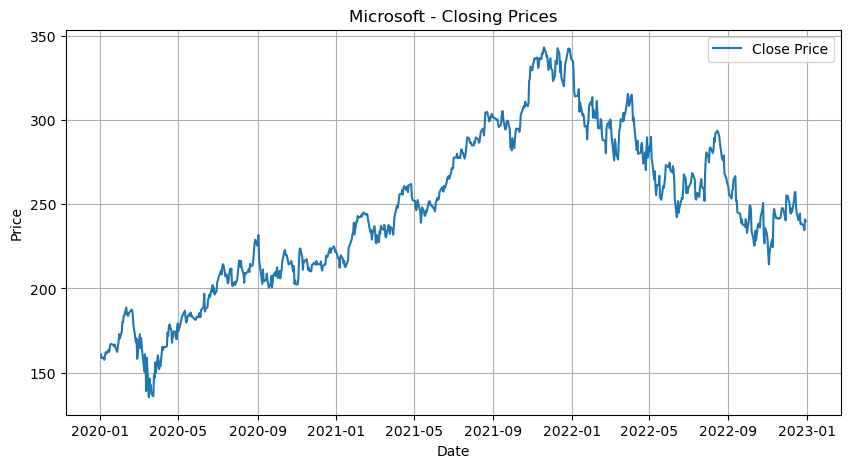

ADF Statistic: -1.8611597491049792
p-value: 0.35054746555615346
The series is non-stationary.
ADF Statistic: -9.128666866571267
p-value: 3.0640942349793812e-15
The series is stationary.


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               MSFT   No. Observations:                  756
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2260.221
Date:                            Sat, 26 Oct 2024   AIC                           4530.442
Time:                                    08:40:08   BIC                           4553.575
Sample:                                         0   HQIC                          4539.353
                                            - 756                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2067      0.226     -0.916      0.360      -0.649       0.235
ma.L1          0.0810      0.233   

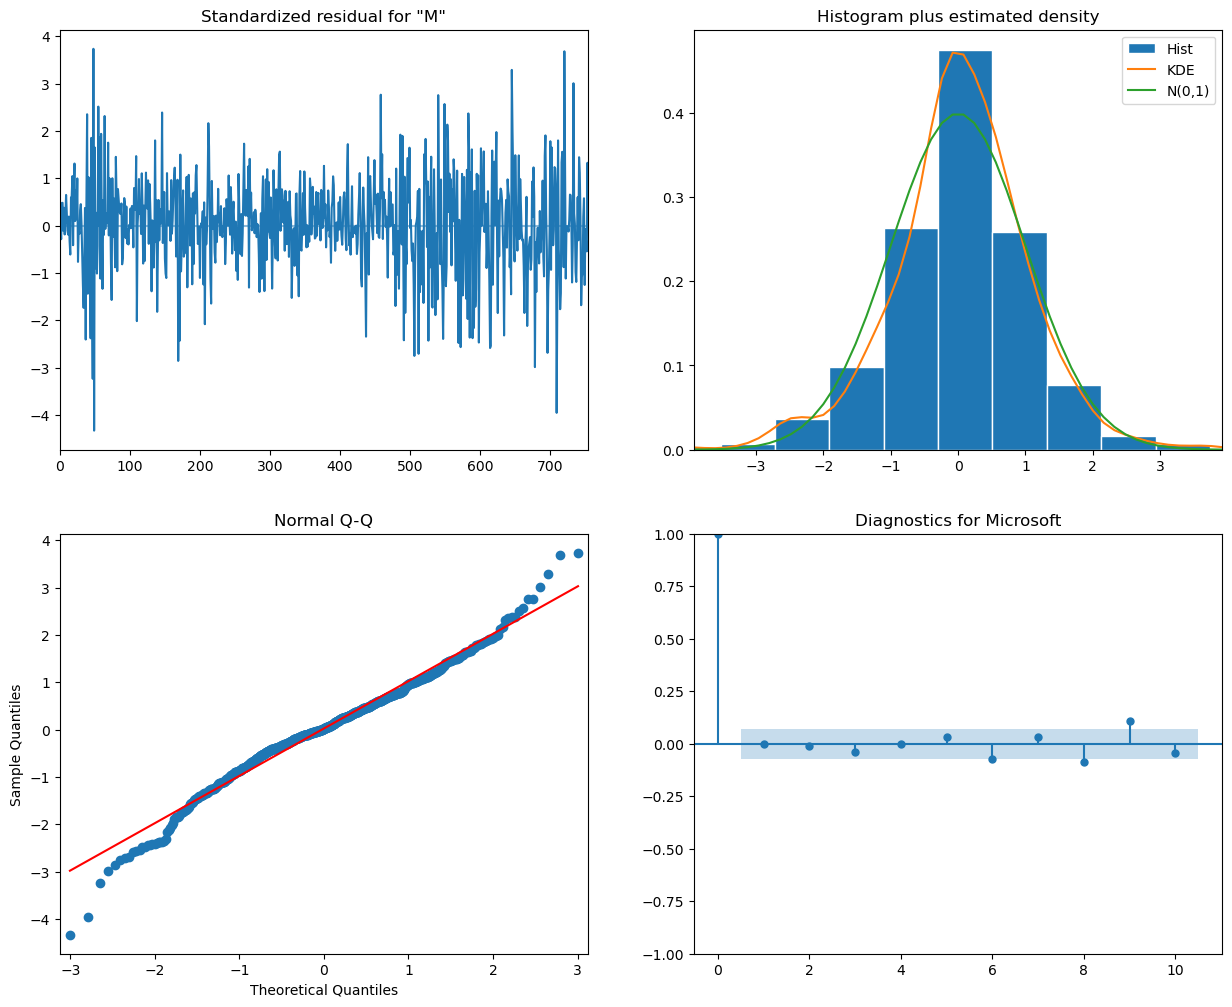


Processing Eurostoxx 50...



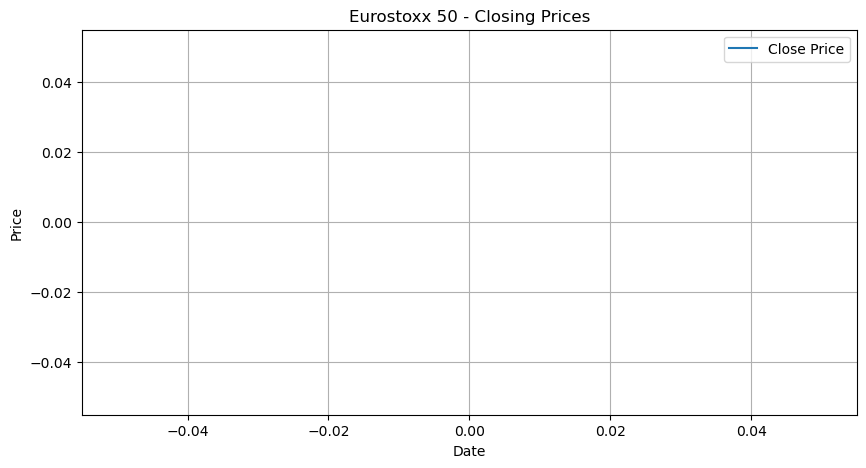

ValueError: zero-size array to reduction operation maximum which has no identity

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "ESTX50": "Eurostoxx 50",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to check stationarity
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Fetch historical price data
data_dict = {}
for symbol in symbols.keys():
    print(f"\nFetching data for {symbols[symbol]} ({symbol})...")
    data = yf.download(symbol, start='2020-01-01', end='2023-01-01', interval='1d')
    data_dict[symbol] = data['Close']  # Keep only the closing prices

# Fit the SARIMAX model for each symbol
for symbol, data in data_dict.items():
    print(f"\nProcessing {symbols[symbol]}...\n")
    
    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Close Price')
    plt.title(f'{symbols[symbol]} - Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    # Check the original data for stationarity
    check_stationarity(data)

    # Apply differencing if necessary
    data_diff = data.diff().dropna()
    
    # Check the differenced data for stationarity
    check_stationarity(data_diff)

    # Fit the SARIMAX model
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=0)

    # Summary of the model
    print(model_fit.summary())

    # Plot the diagnostics
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.title(f'Diagnostics for {symbols[symbol]}')
    plt.show()

    # Make predictions
    


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "ESTX50": "Eurostoxx 50",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to check stationarity
def check_stationarity(ts):
    if len(ts) == 0:
        print("Time series is empty. Cannot check stationarity.")
        return
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Fetch historical price data
data_dict = {}
for symbol in symbols.keys():
    print(f"\nFetching data for {symbols[symbol]} ({symbol})...")
    data = yf.download(symbol, start='2020-01-01', end='2023-01-01', interval='1d')
    data_dict[symbol] = data['Close']  # Keep only the closing prices

# Fit the SARIMAX model for each symbol
for symbol, data in data_dict.items():
    print(f"\nProcessing {symbols[symbol]}...\n")
    
    # Check if data is empty
    if data.isnull().all() or len(data) == 0:
        print(f"No data available for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip to the next symbol if data is not available

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Close Price')
    plt.title(f'{symbols[symbol]} - Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    # Check the original data for stationarity
    check_stationarity(data)

    # Apply differencing if necessary
    data_diff = data.diff().dropna()
    
    # Check the differenced data for stationarity
    check_stationarity(data_diff)

    # Fit the SARIMAX model
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=0)

    # Summary of the model
    print(model_fit.summary())

    # Plot the diagnostics
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.title(f'Diagnostics for {symbols[symbol]}')
    plt.show()

    # Make predictions
    start_date = pd.to_datetime('2022-01-01')  # Define the start date for predictions
    
    # Check if the start_date exists in the data index
    if start_date not in data.index:
        print(f"Start date {start_date} not found in data index. Using the last available date instead.")
        start_date = data.index[-1]  # Use the last available date if not found

    # Generate predictions
    pred = model_fit.get_prediction(start=start_date, dynamic=False)
    pred_conf = pred.conf_int()

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Observed', color='blue')
    plt.plot(pred.predicted_mean, label='Predicted', color='red')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
    plt.title(f'SARIMAX Model Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ESTX50']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for Crude Oil Future (CL=F)...

Fetching data for Microsoft (MSFT)...

Fetching data for Eurostoxx 50 (ESTX50)...

Fetching data for MSCI World (XWD.TO)...

Fetching data for MSCI Emerging Markets (EEM)...

Fetching data for USD/EUR Exchange Rate (EUR=X)...



Processing Crude Oil Future...



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze (removed ESTX50)
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to check stationarity
def check_stationarity(ts):
    if len(ts) == 0:
        print("Time series is empty. Cannot check stationarity.")
        return
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Fetch historical price data
data_dict = {}
for symbol in symbols.keys():
    try:
        print(f"\nFetching data for {symbols[symbol]} ({symbol})...")
        data = yf.download(symbol, start='2020-01-01', end='2023-01-01', interval='1d')
        if data.empty:
            print(f"No data found for {symbols[symbol]} ({symbol}). Skipping.")
            continue
        data_dict[symbol] = data['Close']  # Keep only the closing prices
    except Exception as e:
        print(f"Error fetching data for {symbols[symbol]} ({symbol}): {e}")

# Fit the SARIMAX model for each symbol
for symbol, data in data_dict.items():
    print(f"\nProcessing {symbols[symbol]}...\n")
    
    # Check if data is empty
    if data.isnull().all() or len(data) == 0:
        print(f"No data available for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip to the next symbol if data is not available

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Close Price')
    plt.title(f'{symbols[symbol]} - Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    # Check the original data for stationarity
    check_stationarity(data)

    # Apply differencing if necessary
    data_diff = data.diff().dropna()
    
    # Check the differenced data for stationarity
    check_stationarity(data_diff)

    # Fit the SARIMAX model
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=0)

    # Summary of the model
    print(model_fit.summary())

    # Plot the diagnostics
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.title(f'Diagnostics for {symbols[symbol]}')
    plt.show()

    # Make predictions
    start_date = pd.to_datetime('2022-01-01')  # Define the start date for predictions
    
    # Check if the start_date exists in the data index
    if start_date not in data.index:
        print(f"Start date {start_date} not found in data index. Using the last available date instead.")
        start_date = data.index[-1]  # Use the last available date if not found

    # Generate predictions
    pred = model_fit.get_prediction(start=start_date, dynamic=False)
    pred_conf = pred.conf_int()

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Observed', color='blue')
    plt.plot(pred.predicted_mean, label='Predicted', color='red')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
    plt.title(f'SARIMAX Model Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for Crude Oil Future (CL=F)...

Fetching data for Microsoft (MSFT)...

Fetching data for MSCI World (XWD.TO)...

Fetching data for MSCI Emerging Markets (EEM)...

Fetching data for USD/EUR Exchange Rate (EUR=X)...

Processing Crude Oil Future...



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze (removed ESTX50)
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to check stationarity
def check_stationarity(ts):
    if len(ts) == 0:
        print("Time series is empty. Cannot check stationarity.")
        return
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Fetch historical price data
data_dict = {}
for symbol in symbols.keys():
    try:
        print(f"\nFetching data for {symbols[symbol]} ({symbol})...")
        data = yf.download(symbol, start='2020-01-01', end='2023-01-01', interval='1d')
        if data.empty:
            print(f"No data found for {symbols[symbol]} ({symbol}). Skipping.")
            continue
        data_dict[symbol] = data['Close']  # Keep only the closing prices
    except Exception as e:
        print(f"Error fetching data for {symbols[symbol]} ({symbol}): {e}")

# Fit the SARIMAX model for each symbol
for symbol, data in data_dict.items():
    print(f"\nProcessing {symbols[symbol]}...\n")
    
    # Check if data is empty
    if data.empty or data.isnull().all():
        print(f"No data available for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip to the next symbol if data is not available

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Close Price')
    plt.title(f'{symbols[symbol]} - Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    # Check the original data for stationarity
    check_stationarity(data)

    # Apply differencing if necessary
    data_diff = data.diff().dropna()
    
    # Check the differenced data for stationarity
    check_stationarity(data_diff)

    # Fit the SARIMAX model
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=0)

    # Summary of the model
    print(model_fit.summary())

    # Plot the diagnostics
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.title(f'Diagnostics for {symbols[symbol]}')
    plt.show()

    # Make predictions
    start_date = pd.to_datetime('2022-01-01')  # Define the start date for predictions
    
    # Check if the start_date exists in the data index
    if start_date not in data.index:
        print(f"Start date {start_date} not found in data index. Using the last available date instead.")
        start_date = data.index[-1]  # Use the last available date if not found

    # Generate predictions
    pred = model_fit.get_prediction(start=start_date, dynamic=False)
    pred_conf = pred.conf_int()

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Observed', color='blue')
    plt.plot(pred.predicted_mean, label='Predicted', color='red')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
    plt.title(f'SARIMAX Model Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for Crude Oil Future (CL=F)...

Fetching data for Microsoft (MSFT)...

Fetching data for MSCI World (XWD.TO)...

Fetching data for MSCI Emerging Markets (EEM)...

Fetching data for USD/EUR Exchange Rate (EUR=X)...

Processing Crude Oil Future...



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to check stationarity
def check_stationarity(ts):
    if ts.empty:
        print("Time series is empty. Cannot check stationarity.")
        return
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Fetch historical price data
data_dict = {}
for symbol in symbols.keys():
    try:
        print(f"\nFetching data for {symbols[symbol]} ({symbol})...")
        data = yf.download(symbol, start='2020-01-01', end='2023-01-01', interval='1d')
        if data.empty:
            print(f"No data found for {symbols[symbol]} ({symbol}). Skipping.")
            continue
        data_dict[symbol] = data['Close']  # Keep only the closing prices
    except Exception as e:
        print(f"Error fetching data for {symbols[symbol]} ({symbol}): {e}")

# Fit the SARIMAX model for each symbol
for symbol, data in data_dict.items():
    print(f"\nProcessing {symbols[symbol]}...\n")

    # Check if data is empty or all values are null
    if data.empty:
        print(f"No data available for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip to the next symbol if data is not available
    if data.isnull().all():
        print(f"All values are null for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip if all values are null

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Close Price')
    plt.title(f'{symbols[symbol]} - Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    # Check the original data for stationarity
    check_stationarity(data)

    # Apply differencing if necessary
    data_diff = data.diff().dropna()

    # Check the differenced data for stationarity
    check_stationarity(data_diff)

    # Fit the SARIMAX model
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=0)

    # Summary of the model
    print(model_fit.summary())

    # Plot the diagnostics
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.title(f'Diagnostics for {symbols[symbol]}')
    plt.show()

    # Make predictions
    start_date = pd.to_datetime('2022-01-01')  # Define the start date for predictions

    # Check if the start_date exists in the data index
    if start_date not in data.index:
        print(f"Start date {start_date} not found in data index. Using the last available date instead.")
        start_date = data.index[-1]  # Use the last available date if not found

    # Generate predictions
    pred = model_fit.get_prediction(start=start_date, dynamic=False)
    pred_conf = pred.conf_int()

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Observed', color='blue')
    plt.plot(pred.predicted_mean, label='Predicted', color='red')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
    plt.title(f'SARIMAX Model Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for Crude Oil Future (CL=F)...

Fetching data for Microsoft (MSFT)...

Fetching data for MSCI World (XWD.TO)...

Fetching data for MSCI Emerging Markets (EEM)...

Fetching data for USD/EUR Exchange Rate (EUR=X)...

Processing Crude Oil Future...



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to check stationarity
def check_stationarity(ts):
    if ts.empty:
        print("Time series is empty. Cannot check stationarity.")
        return
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Fetch historical price data
data_dict = {}
for symbol in symbols.keys():
    try:
        print(f"\nFetching data for {symbols[symbol]} ({symbol})...")
        data = yf.download(symbol, start='2020-01-01', end='2023-01-01', interval='1d')
        
        # Print the retrieved data for debugging
        print("Data retrieved:")
        print(data)
        
        if data.empty:
            print(f"No data found for {symbols[symbol]} ({symbol}). Skipping.")
            continue
        data_dict[symbol] = data['Close']  # Keep only the closing prices
    except Exception as e:
        print(f"Error fetching data for {symbols[symbol]} ({symbol}): {e}")

# Fit the SARIMAX model for each symbol
for symbol, data in data_dict.items():
    print(f"\nProcessing {symbols[symbol]}...\n")

    # Print the type and first few rows of the data for debugging
    print("Type of data:", type(data))
    print("First few rows of data:")
    print(data.head())

    # Check if data is empty or all values are null
    if data.empty:
        print(f"No data available for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip to the next symbol if data is not available

    # Check for null values explicitly
    null_count = data.isnull().sum()
    if null_count == len(data):
        print(f"All values are null for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip if all values are null
    
    # Print the count of null values for debugging
    print(f"Null values count for {symbols[symbol]}: {null_count}")

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Close Price')
    plt.title(f'{symbols[symbol]} - Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.legend()
    plt.show()

    # Check the original data for stationarity
    check_stationarity(data)

    # Apply differencing if necessary
    data_diff = data.diff().dropna()

    # Check the differenced data for stationarity
    check_stationarity(data_diff)

    # Fit the SARIMAX model
    p, d, q = 1, 1, 1  # ARIMA parameters
    P, D, Q, S = 1, 0, 1, 12  # Seasonal parameters (adjust as needed)

    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=0)

    # Summary of the model
    print(model_fit.summary())

    # Plot the diagnostics
    model_fit.plot_diagnostics(figsize=(15, 12))
    plt.title(f'Diagnostics for {symbols[symbol]}')
    plt.show()

    # Make predictions
    start_date = pd.to_datetime('2022-01-01')  # Define the start date for predictions

    # Check if the start_date exists in the data index
    if start_date not in data.index:
        print(f"Start date {start_date} not found in data index. Using the last available date instead.")
        start_date = data.index[-1]  # Use the last available date if not found

    # Generate predictions
    pred = model_fit.get_prediction(start=start_date, dynamic=False)
    pred_conf = pred.conf_int()

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Observed', color='blue')
    plt.plot(pred.predicted_mean, label='Predicted', color='red')
    plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
    plt.title(f'SARIMAX Model Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for Crude Oil Future (CL=F)...
Data retrieved:
Price                      Adj Close      Close       High        Low  \
Ticker                          CL=F       CL=F       CL=F       CL=F   
Date                                                                    
2020-01-02 00:00:00+00:00  61.180000  61.180000  61.599998  60.639999   
2020-01-03 00:00:00+00:00  63.049999  63.049999  64.089996  61.130001   
2020-01-06 00:00:00+00:00  63.270000  63.270000  64.720001  62.639999   
2020-01-07 00:00:00+00:00  62.700001  62.700001  63.150002  62.110001   
2020-01-08 00:00:00+00:00  59.610001  59.610001  65.650002  59.150002   
...                              ...        ...        ...        ...   
2022-12-23 00:00:00+00:00  79.559998  79.559998  80.330002  77.980003   
2022-12-27 00:00:00+00:00  79.529999  79.529999  81.180000  79.160004   
2022-12-28 00:00:00+00:00  78.959999  78.959999  79.919998  77.300003   
2022-12-29 00:00:00+00:00  78.400002  78.400002  78.820000  76

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Data retrieved for Crude Oil Future:
Price                      Adj Close      Close       High        Low  \
Ticker                          CL=F       CL=F       CL=F       CL=F   
Date                                                                    
2020-01-02 00:00:00+00:00  61.180000  61.180000  61.599998  60.639999   
2020-01-03 00:00:00+00:00  63.049999  63.049999  64.089996  61.130001   
2020-01-06 00:00:00+00:00  63.270000  63.270000  64.720001  62.639999   
2020-01-07 00:00:00+00:00  62.700001  62.700001  63.150002  62.110001   
2020-01-08 00:00:00+00:00  59.610001  59.610001  65.650002  59.150002   

Price                           Open   Volume  
Ticker                          CL=F     CL=F  
Date                                           
2020-01-02 00:00:00+00:00  61.599998   486873  
2020-01-03 00:00:00+00:00  61.180000   885861  
2020-01-06 00:00:00+00:00  63.709999   724236  
2020-01-07 00:00:00+00:00  62.910000   582649  
2020-01-08 00:00:00+00:00  62.840000  1205

c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


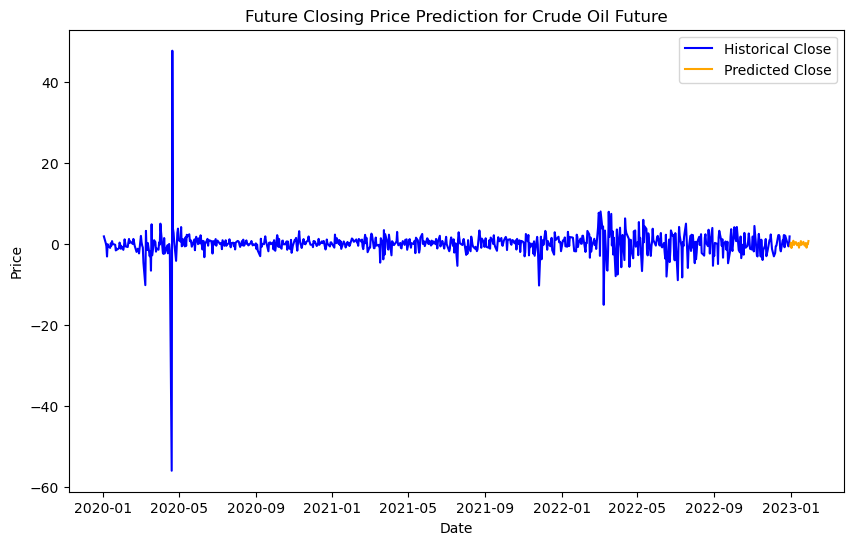


Predicting future values for Microsoft...
ADF Statistic: -1.8611597491049792
p-value: 0.35054746555615346
Data is not stationary, differencing...


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

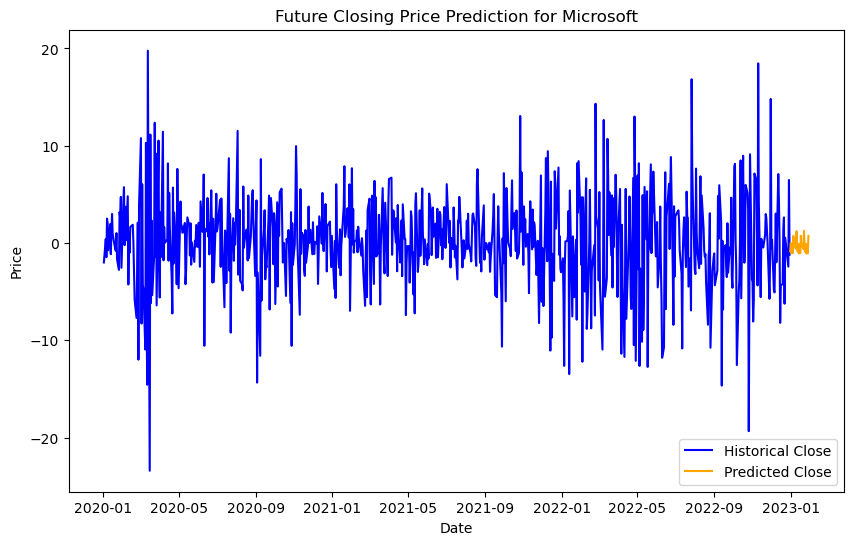


Predicting future values for MSCI World...
ADF Statistic: -1.7082672005040962
p-value: 0.4268580791980855
Data is not stationary, differencing...


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

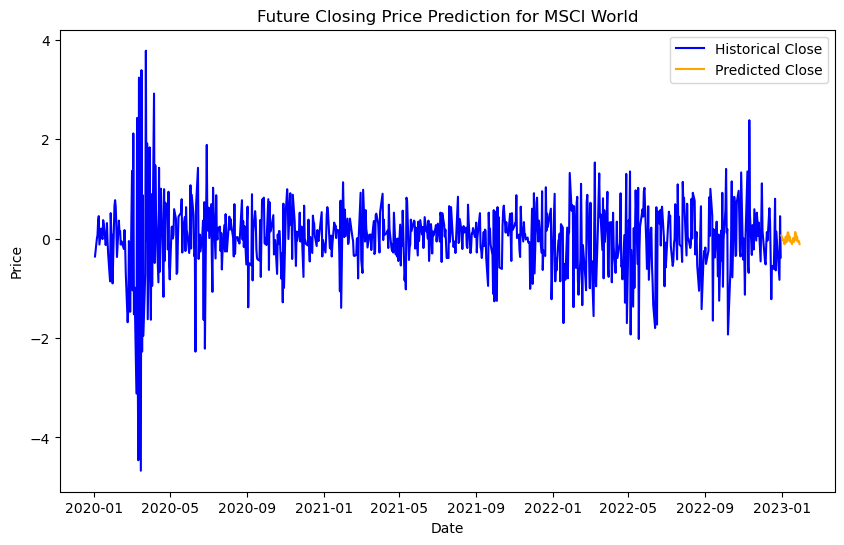


Predicting future values for MSCI Emerging Markets...
ADF Statistic: -0.9892202230428546
p-value: 0.7571756440363626
Data is not stationary, differencing...


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

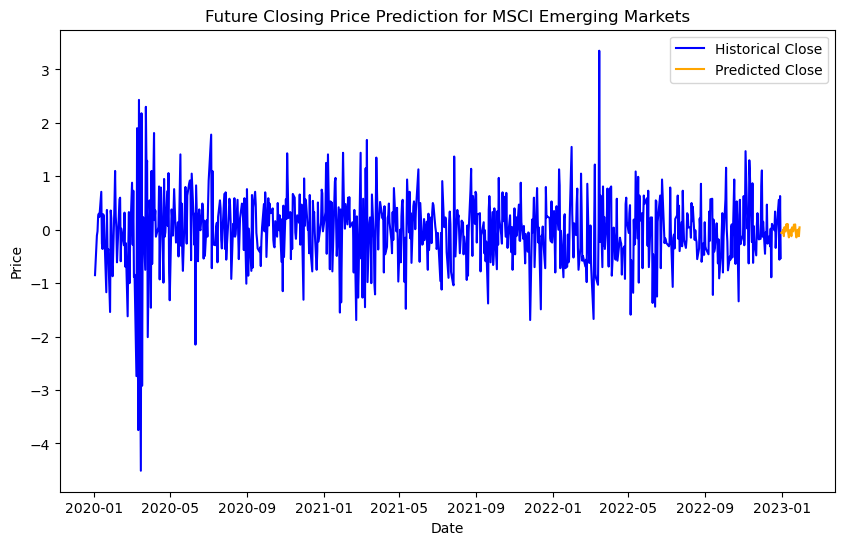


Predicting future values for USD/EUR Exchange Rate...
ADF Statistic: -0.8818406482826733
p-value: 0.7938937186991855
Data is not stationary, differencing...


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


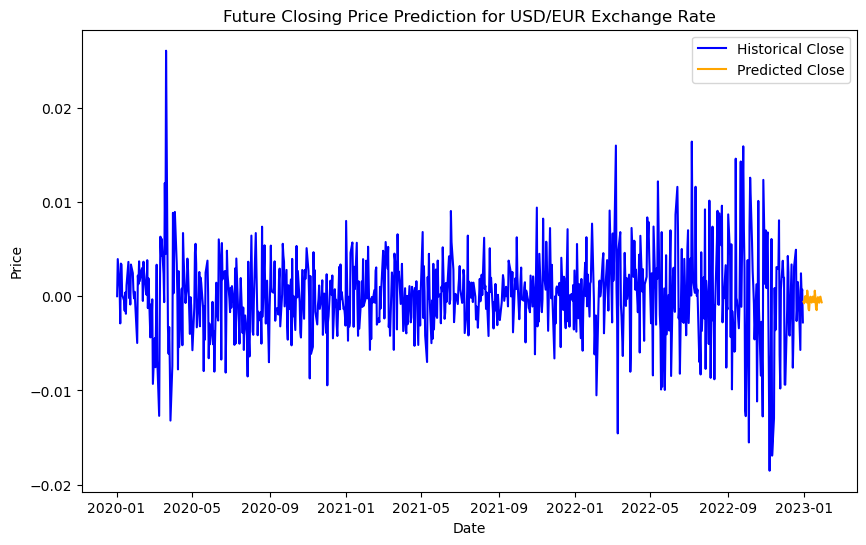

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Fetch data from Yahoo Finance
data_dict = {}
for symbol in symbols.keys():
    try:
        data = yf.download(symbol, start="2020-01-01", end="2023-01-01")
        data_dict[symbol] = data
        print(f"Data retrieved for {symbols[symbol]}:\n{data.head()}")  # Preview the first few rows
    except Exception as e:
        print(f"Error retrieving data for {symbols[symbol]} ({symbol}): {e}")

# Function to check stationarity
def check_stationarity(ts):
    if ts.empty:
        print("Time series is empty. Cannot check stationarity.")
        return
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1] <= 0.05  # Return True if stationary

# Function to fit the SARIMA model and predict future values
def predict_future(symbol, data, steps=30):
    print(f"\nPredicting future values for {symbols[symbol]}...")
    # Ensure we're working with the 'Close' column
    close_data = data['Close'].dropna()

    # Check if the time series is stationary
    if not check_stationarity(close_data):
        print("Data is not stationary, differencing...")
        close_data = close_data.diff().dropna()  # Difference the data to make it stationary

    # Fit the SARIMA model (p,d,q) parameters can be tuned based on ACF and PACF plots
    model = SARIMAX(close_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)

    # Forecasting future values
    future = results.get_forecast(steps=steps)
    future_index = pd.date_range(start=close_data.index[-1] + pd.Timedelta(days=1), periods=steps)
    future_values = future.predicted_mean

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(close_data.index, close_data, label='Historical Close', color='blue')
    plt.plot(future_index, future_values, label='Predicted Close', color='orange')
    plt.title(f'Future Closing Price Prediction for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Process each symbol's data
for symbol, data in data_dict.items():
    # Check if data is empty
    if data.empty:
        print(f"No data available for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip to the next symbol if data is not available
    
    # Check for null values explicitly
    null_count = data.isnull().sum().sum()  # Total number of null values
    total_count = data.size  # Total number of entries in the DataFrame
    
    if null_count == total_count:
        print(f"All values are null for {symbols[symbol]} ({symbol}). Skipping.")
        continue  # Skip if all values are null
    
    # Predict future values and plot for each symbol
    predict_future(symbol, data)


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import pytz

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "ESTX50.PR": "Eurostoxx 50",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Fetch data from Yahoo Finance
data_dict = {}
for symbol in symbols.keys():
    try:
        data = yf.download(symbol, start="2020-01-01", end="2024-11-04", progress=False)
        data_dict[symbol] = data
    except Exception as e:
        print(f"Error retrieving data for {symbols[symbol]} ({symbol}): {e}")

# Function to predict future prices
def predict_future(symbol, data, steps=30):
    # Ensure we're working with the 'Close' column
    close_data = data['Close'].dropna()

    # Fit the SARIMA model
    model = SARIMAX(close_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)

    # Forecasting future values
    future = results.get_forecast(steps=steps)
    return future.predicted_mean

# Prepare to predict prices for January 7, 2025
predictions = {}
# Make the target date timezone-aware (UTC in this case)
target_date = pd.Timestamp(datetime(2025, 1, 7), tz='UTC')

# Calculate the number of steps to forecast until January 7, 2025
last_data_date = pd.Timestamp(data_dict[list(data_dict.keys())[0]].index[-1])
steps_to_forecast = (target_date - last_data_date).days

for symbol, data in data_dict.items():
    predictions[symbol] = predict_future(symbol, data, steps=steps_to_forecast)[-1]

# Prepare the email content
email_content = "Team F: "
email_content += ", ".join([f"{symbol} {predictions[symbol]:.2f}" for symbol in predictions])
print(email_content)  # Print the email content to send



1 Failed download:
['ESTX50.PR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No suppor

KeyError: -1

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import pytz

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "ESTX50.PR": "Eurostoxx 50",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Fetch data from Yahoo Finance
data_dict = {}
for symbol in symbols.keys():
    try:
        data = yf.download(symbol, start="2020-01-01", end="2024-11-04", progress=False)
        data_dict[symbol] = data
    except Exception as e:
        print(f"Error retrieving data for {symbols[symbol]} ({symbol}): {e}")

# Function to predict future prices
def predict_future(symbol, data, steps=30):
    # Ensure we're working with the 'Close' column
    close_data = data['Close'].dropna()

    # Fit the SARIMA model
    model = SARIMAX(close_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)

    # Forecasting future values
    future = results.get_forecast(steps=steps)
    return future.predicted_mean

# Prepare to predict prices for January 7, 2025
predictions = {}
# Make the target date timezone-aware (UTC in this case)
target_date = pd.Timestamp(datetime(2025, 1, 7), tz='UTC')

# Calculate the number of steps to forecast until January 7, 2025
last_data_date = pd.Timestamp(data_dict[list(data_dict.keys())[0]].index[-1])
steps_to_forecast = (target_date - last_data_date).days

for symbol, data in data_dict.items():
    predicted_values = predict_future(symbol, data, steps=steps_to_forecast)

    # Check if predictions are not empty
    if not predicted_values.empty:
        predictions[symbol] = predicted_values[-1]  # Get the last predicted value
    else:
        print(f"No predictions available for {symbols[symbol]} ({symbol}).")

# Prepare the email content
email_content = "Team F: "
email_content += ", ".join([f"{symbol} {predictions[symbol]:.2f}" for symbol in predictions])
print(email_content)  # Print the email content to send



1 Failed download:
['ESTX50.PR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No suppor

KeyError: -1

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import pytz

# Define the symbols to analyze
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "ESTX50.PR": "Eurostoxx 50",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Fetch data from Yahoo Finance
data_dict = {}
for symbol in symbols.keys():
    try:
        data = yf.download(symbol, start="2020-01-01", end="2024-11-04", progress=False)
        data_dict[symbol] = data
    except Exception as e:
        print(f"Error retrieving data for {symbols[symbol]} ({symbol}): {e}")

# Function to predict future prices
def predict_future(symbol, data, steps=30):
    # Ensure we're working with the 'Close' column
    close_data = data['Close'].dropna()

    if close_data.empty:
        print(f"No close data available for {symbol}.")
        return pd.Series()  # Return an empty Series

    # Fit the SARIMA model
    model = SARIMAX(close_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)

    # Forecasting future values
    future = results.get_forecast(steps=steps)
    return future.predicted_mean

# Prepare to predict prices for January 7, 2025
predictions = {}
# Make the target date timezone-aware (UTC in this case)
target_date = pd.Timestamp(datetime(2025, 1, 7), tz='UTC')

# Calculate the number of steps to forecast until January 7, 2025
last_data_date = pd.Timestamp(data_dict[list(data_dict.keys())[0]].index[-1])
steps_to_forecast = (target_date - last_data_date).days

for symbol, data in data_dict.items():
    predicted_values = predict_future(symbol, data, steps=steps_to_forecast)

    # Check if predictions are not empty
    if not predicted_values.empty:
        predictions[symbol] = predicted_values.iloc[-1]  # Use iloc for index access
    else:
        print(f"No predictions available for {symbols[symbol]} ({symbol}).")

# Prepare the email content
email_content = "Team F: "
email_content += ", ".join([f"{symbol} {predictions[symbol]:.2f}" for symbol in predictions])
print(email_content)  # Print the email content to send



1 Failed download:
['ESTX50.PR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No suppor

No close data available for ESTX50.PR.
No predictions available for Eurostoxx 50 (ESTX50.PR).


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be igno

Team F: CL=F 70.65, MSFT 443.63, XWD.TO 96.73, EEM 45.26, EUR=X 0.94


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import pytz

# Define the symbols to analyze (removed Eurostoxx 50)
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Fetch data from Yahoo Finance
data_dict = {}
for symbol in symbols.keys():
    try:
        data = yf.download(symbol, start="2020-01-01", end="2024-11-04", progress=False)
        data_dict[symbol] = data
    except Exception as e:
        print(f"Error retrieving data for {symbols[symbol]} ({symbol}): {e}")

# Function to predict future prices
def predict_future(symbol, data, steps=30):
    # Ensure we're working with the 'Close' column
    close_data = data['Close'].dropna()

    if close_data.empty:
        print(f"No close data available for {symbol}.")
        return pd.Series()  # Return an empty Series

    # Fit the SARIMA model
    model = SARIMAX(close_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)

    # Forecasting future values
    future = results.get_forecast(steps=steps)
    return future.predicted_mean

# Prepare to predict prices for January 7, 2025
predictions = {}
# Make the target date timezone-aware (UTC in this case)
target_date = pd.Timestamp(datetime(2025, 1, 7), tz='UTC')

# Calculate the number of steps to forecast until January 7, 2025
last_data_date = pd.Timestamp(data_dict[list(data_dict.keys())[0]].index[-1])
steps_to_forecast = (target_date - last_data_date).days

for symbol, data in data_dict.items():
    predicted_values = predict_future(symbol, data, steps=steps_to_forecast)

    # Check if predictions are not empty
    if not predicted_values.empty:
        predictions[symbol] = predicted_values.iloc[-1]  # Use iloc for index access
    else:
        print(f"No predictions available for {symbols[symbol]} ({symbol}).")

# Prepare the email content
email_content = "Team F: "
email_content += ", ".join([f"{symbol} {predictions[symbol]:.2f}" for symbol in predictions])
print(email_content)  # Print the email content to send


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

Team F: CL=F 70.65, MSFT 443.63, XWD.TO 96.73, EEM 45.26, EUR=X 0.94


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import pytz

# Define the symbols to analyze (removed Eurostoxx 50)
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Fetch data from Yahoo Finance
data_dict = {}
for symbol in symbols.keys():
    try:
        data = yf.download(symbol, start="2020-01-01", end="2024-11-04", progress=False)
        data_dict[symbol] = data
    except Exception as e:
        print(f"Error retrieving data for {symbols[symbol]} ({symbol}): {e}")

# Function to predict future prices
def predict_future(symbol, data, steps=30):
    # Ensure we're working with the 'Close' column
    close_data = data['Close'].dropna()

    if close_data.empty:
        print(f"No close data available for {symbol}.")
        return pd.Series()  # Return an empty Series

    # Fit the SARIMA model
    model = SARIMAX(close_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)

    # Forecasting future values
    future = results.get_forecast(steps=steps)
    forecast_index = pd.date_range(start=close_data.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')
    future_indexed = pd.Series(future.predicted_mean.values, index=forecast_index)

    return future_indexed

# Prepare to predict prices for January 7, 2025
predictions = {}
# Make the target date timezone-aware (UTC in this case)
target_date = pd.Timestamp(datetime(2025, 1, 7), tz='UTC')

# Calculate the number of steps to forecast until January 7, 2025
last_data_date = pd.Timestamp(data_dict[list(data_dict.keys())[0]].index[-1])
steps_to_forecast = (target_date - last_data_date).days

for symbol, data in data_dict.items():
    predicted_values = predict_future(symbol, data, steps=steps_to_forecast)

    # Check if predictions are not empty
    if not predicted_values.empty:
        predictions[symbol] = predicted_values.iloc[-1]  # Use iloc for index access
    else:
        print(f"No predictions available for {symbols[symbol]} ({symbol}).")

# Prepare the email content
email_content = "Team D: "
email_content += ", ".join([f"{symbols[symbol]} {predictions[symbol]:.2f}" for symbol in predictions])
print(email_content)  # Print the email content to send


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

Team D: Crude Oil Future 70.65, Microsoft 443.63, MSCI World 96.73, MSCI Emerging Markets 45.26, USD/EUR Exchange Rate 0.94


c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


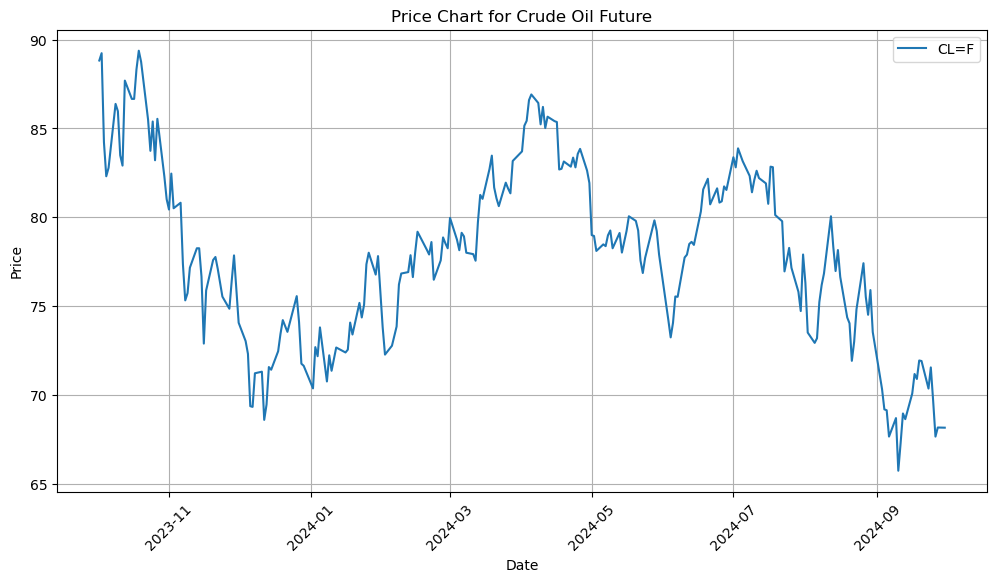

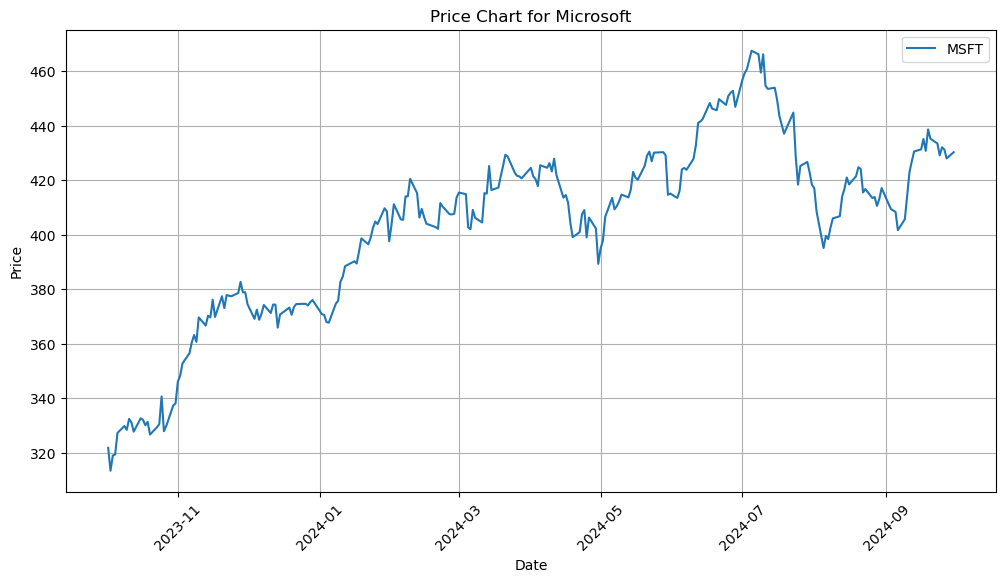

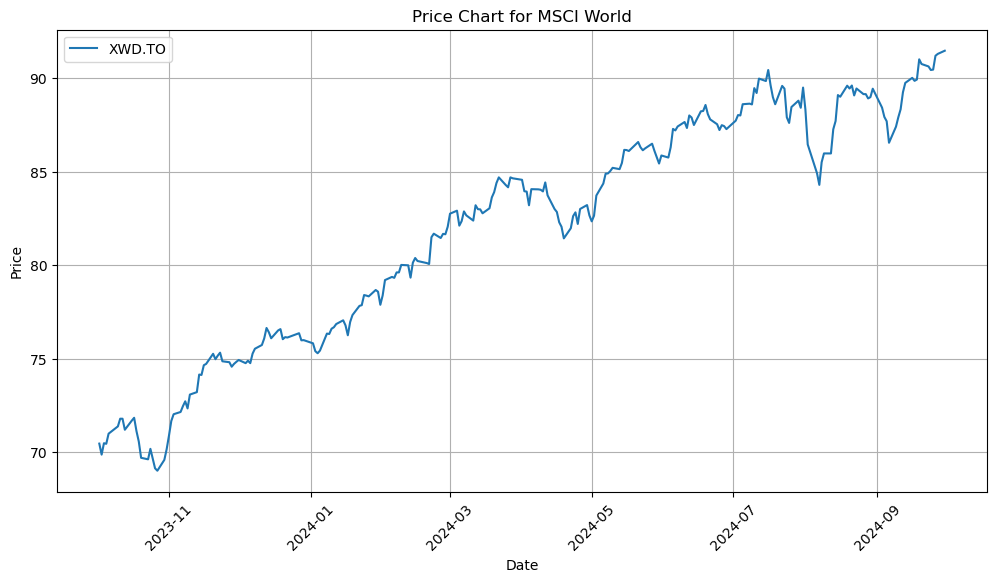

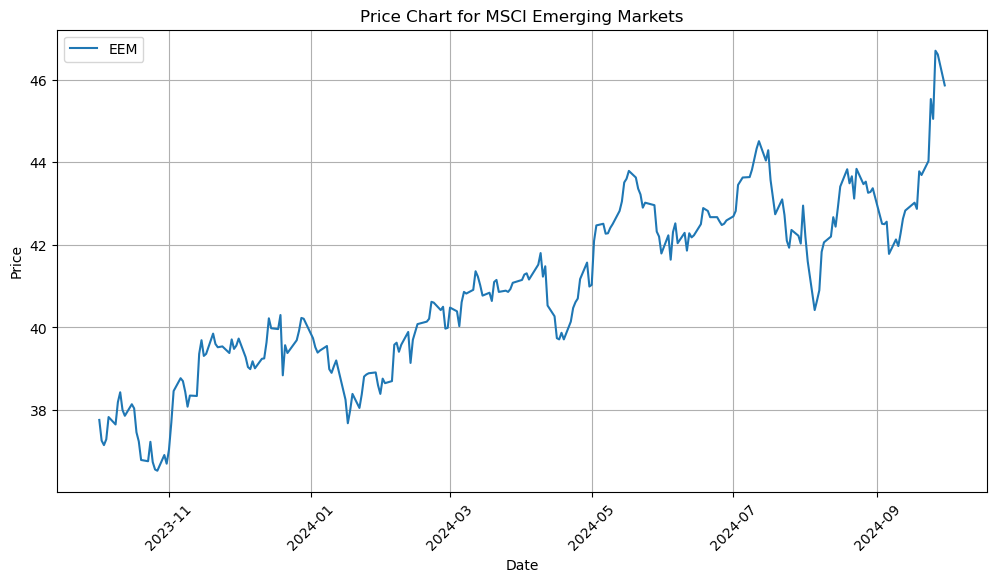

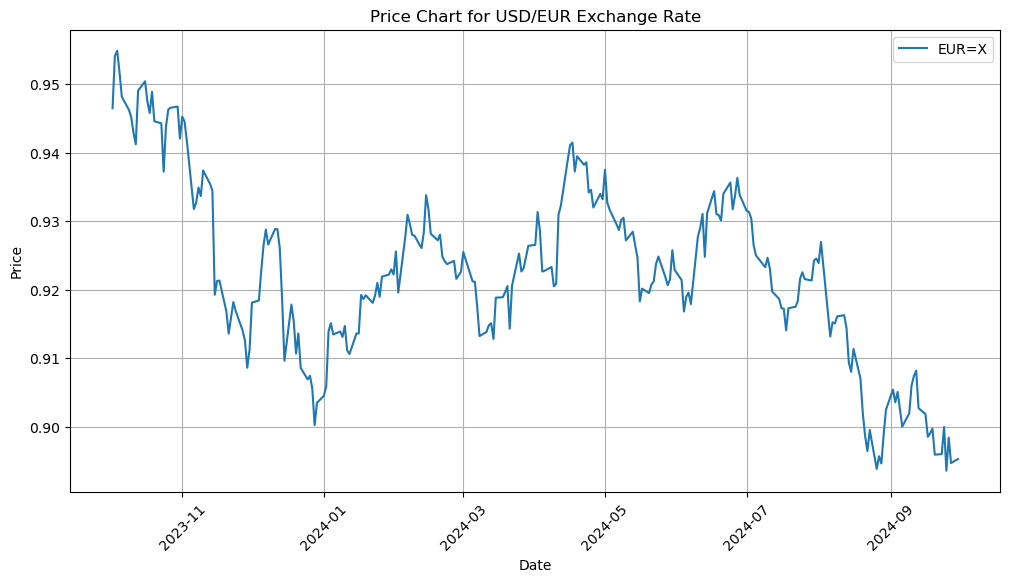

In [36]:
import matplotlib.pyplot as plt
from datetime import datetime

# Function to plot price data for each symbol
def plot_prices(data_dict, start_date, end_date):
    for symbol, data in data_dict.items():
        plt.figure(figsize=(12, 6))
        plt.plot(data.loc[start_date:end_date]['Close'], label=symbol)
        plt.title(f'Price Chart for {symbols[symbol]}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.grid()
        plt.legend()
        plt.show()

# Define the time period for the price charts
start_date = '2023-10-01'
end_date = '2024-09-30'

# Plot prices
plot_prices(data_dict, start_date, end_date)


In [37]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window).mean()
    rolling_std = data['Close'].rolling(window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band


AttributeError: 'numpy.float64' object has no attribute 'index'

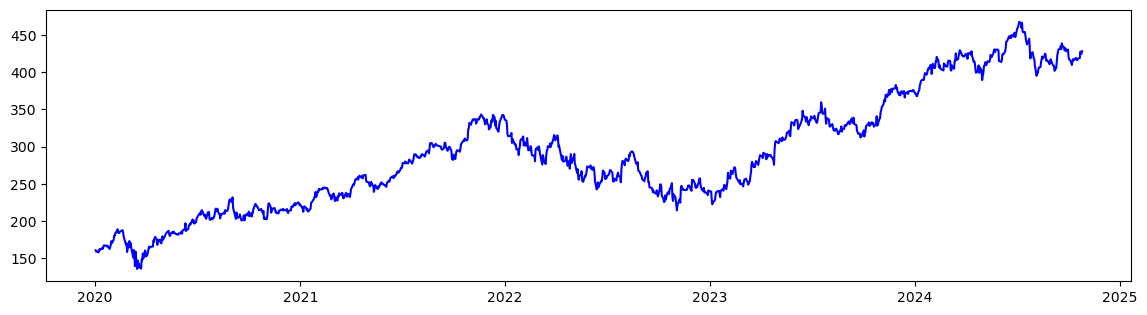

In [38]:
import matplotlib.pyplot as plt

# Assuming 'predicted_values' contains the predictions for MSFT
symbol = 'MSFT'
data = data_dict[symbol]

# Calculate indicators
macd, signal = calculate_macd(data)
rsi = calculate_rsi(data)
upper_band, lower_band = calculate_bollinger_bands(data)

# Get predicted values for the future (ensure this is a Series)
predicted_values = predictions[symbol]  # from your prediction step

# Plotting
plt.figure(figsize=(14, 12))

# Price and Predictions
plt.subplot(3, 1, 1)
plt.plot(data['Close'], label='Actual Price', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted Price', color='orange')
plt.title(f'Price and Predictions for {symbols[symbol]}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# MACD and Signal
plt.subplot(3, 1, 2)
plt.plot(macd, label='MACD', color='green')
plt.plot(signal, label='Signal Line', color='red')
plt.title('MACD for {symbols[symbol]}')
plt.legend()

# RSI
plt.subplot(3, 1, 3)
plt.plot(rsi, label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.title('RSI for {symbols[symbol]}')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA

# Define the symbols
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to fetch historical prices
def fetch_data(symbol):
    try:
        data = yf.download(symbol, start="2020-01-01", end="2023-09-30", interval="1d")
        return data[['Close']]
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Function to predict future prices
def predict_future(symbol, data, steps=1):
    model = ARIMA(data['Close'], order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(steps=steps)[0]
    
    # Create a date range for the future predictions
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='B')
    
    return pd.Series(forecast, index=future_dates)

# Function to calculate MACD
def calculate_macd(data):
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Dictionary to 


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA

# Define the symbols
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to fetch historical prices
def fetch_data(symbol):
    try:
        data = yf.download(symbol, start="2020-01-01", end="2023-09-30", interval="1d")
        return data[['Close']]
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Function to predict future prices
def predict_future(symbol, data, steps=1):
    model = ARIMA(data['Close'], order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(steps=steps)[0]
    
    # Create a date range for the future predictions
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='B')
    
    return pd.Series(forecast, index=future_dates)

# Function to calculate MACD
def calculate_macd(data):
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Dictionary to hold data for each symbol
data_dict = {}

# Fetch data for each symbol
for symbol in symbols.keys():
    data = fetch_data(symbol)
    if data is not None:
        data_dict[symbol] = data

# Predictions and indicators storage
predictions = {}
for symbol, data in data_dict.items():
    # Predict future price for the next business day
    predictions[symbol] = predict_future(symbol, data, steps=1)

    # Calculate MACD and RSI
    macd, signal = calculate_macd(data)
    rsi = calculate_rsi(data)

    # Plotting
    plt.figure(figsize=(14, 12))

    # Price and Predictions
    plt.subplot(3, 1, 1)
    plt.plot(data['Close'], label='Actual Price', color='blue')
    plt.plot(predictions[symbol].index, predictions[symbol].values, label='Predicted Price', color='orange')
    plt.title(f'Price and Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # MACD and Signal
    plt.subplot(3, 1, 2)
    plt.plot(macd, label='MACD', color='green')
    plt.plot(signal, label='Signal Line', color='red')
    plt.title(f'MACD for {symbols[symbol]}')
    plt.legend()

    # RSI
    plt.subplot(3, 1, 3)
    plt.plot(rsi, label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')
    plt.title(f'RSI for {symbols[symbol]}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Output predictions for email
email_content = "Team D: "
for symbol in symbols.keys():
    email_content += f"{symbols[symbol]}: {predictions[symbol].values[-1]:.2f}, "

# Print email content
print(email_content[:-2])  # Remove trailing comma and space


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

TypeError: ARIMA.fit() got an unexpected keyword argument 'disp'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

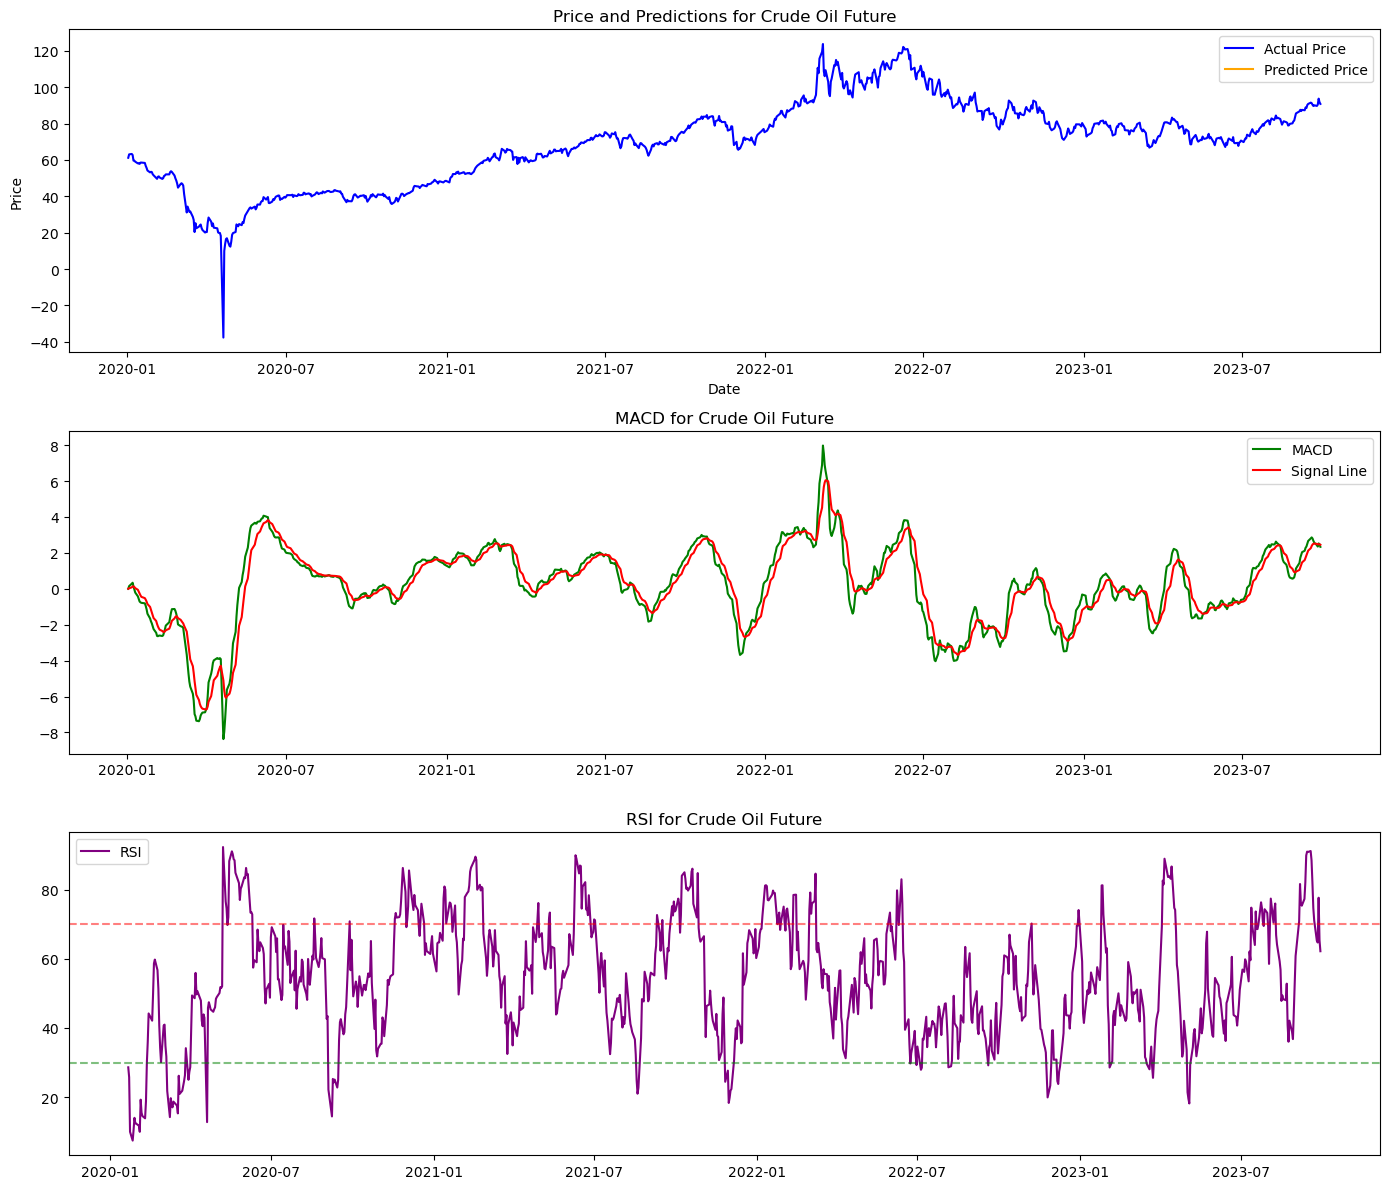

c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

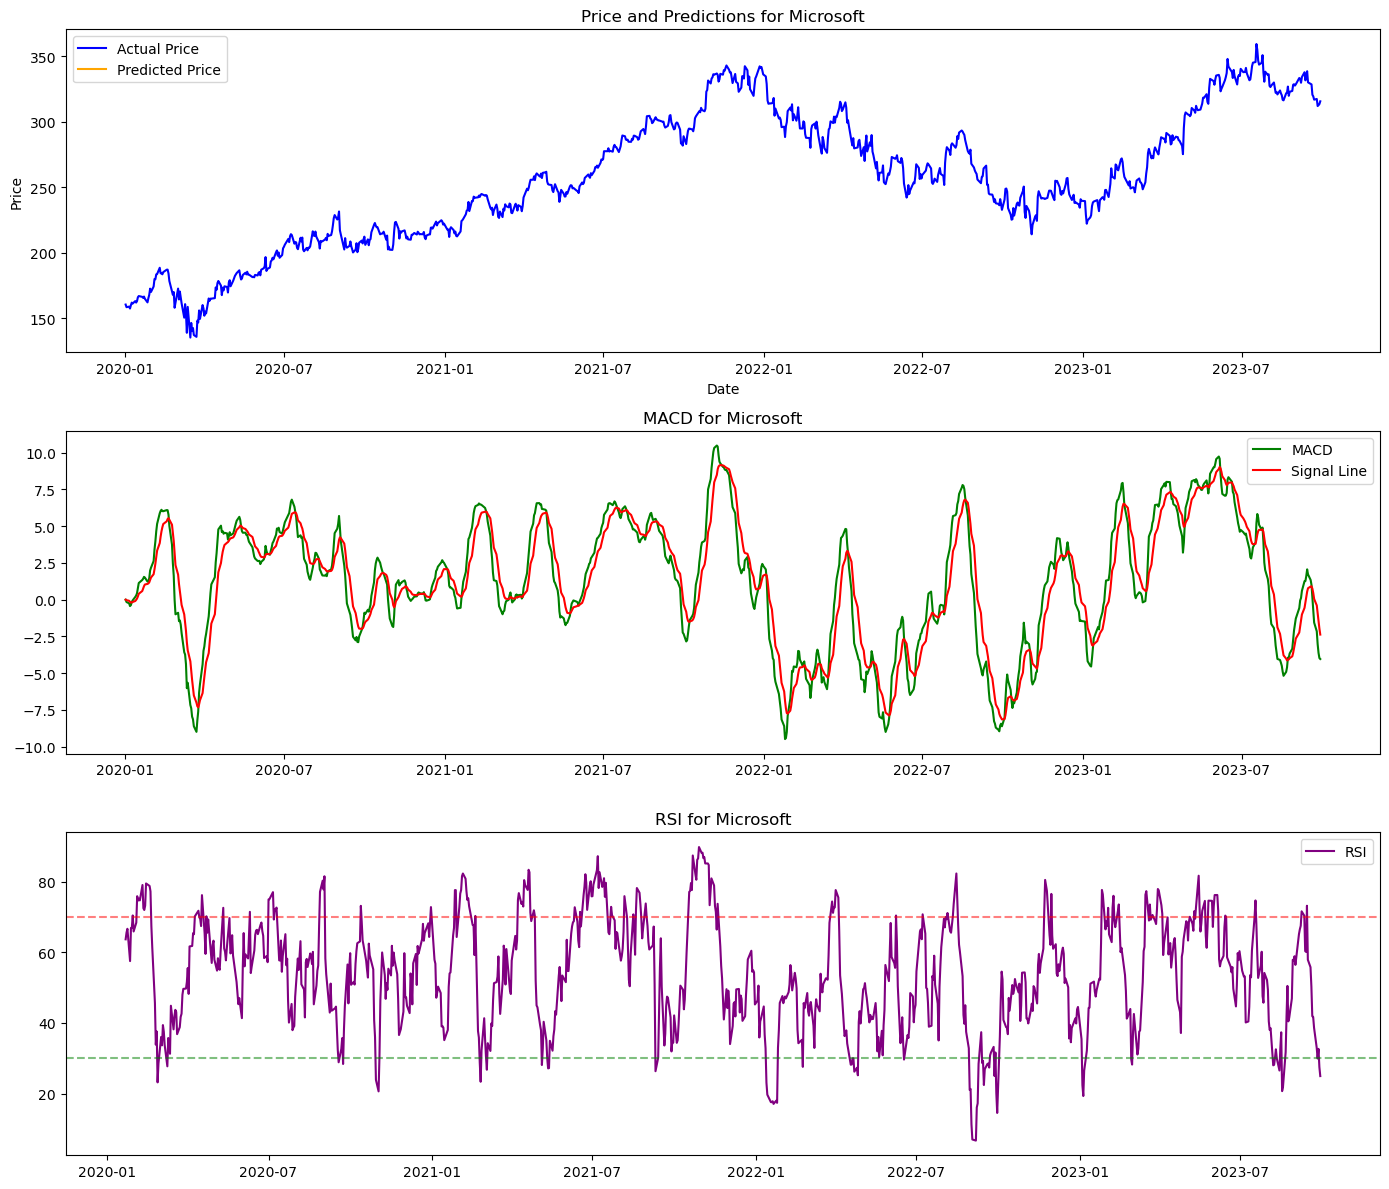

c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

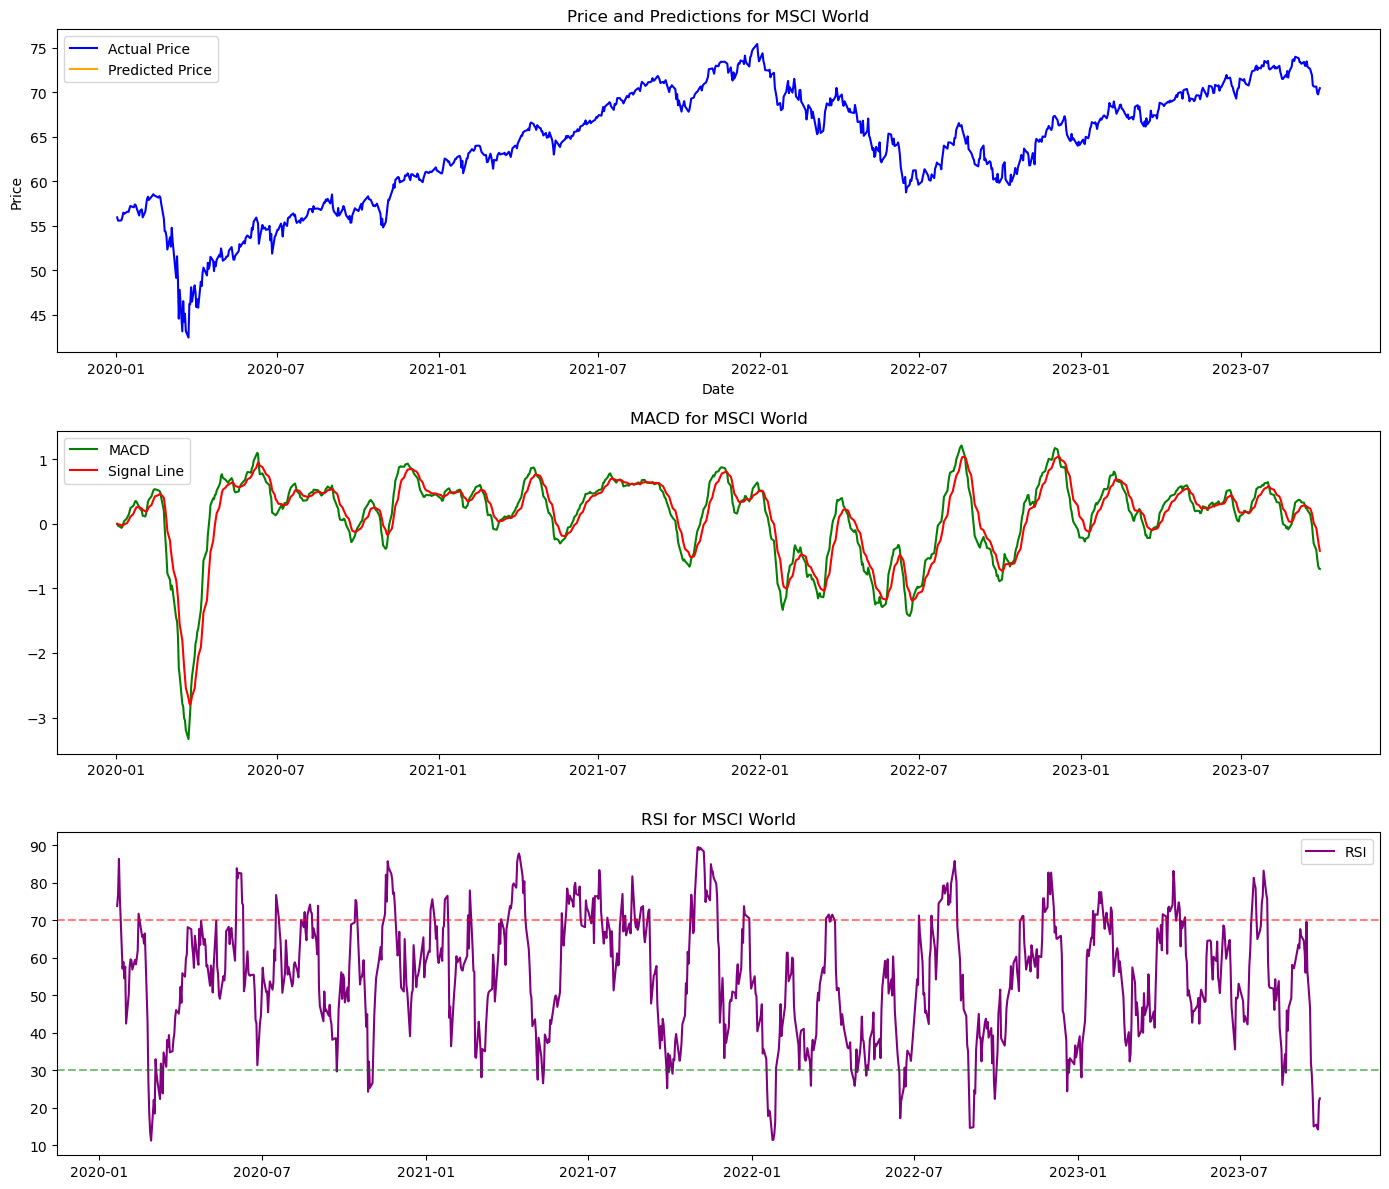

c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

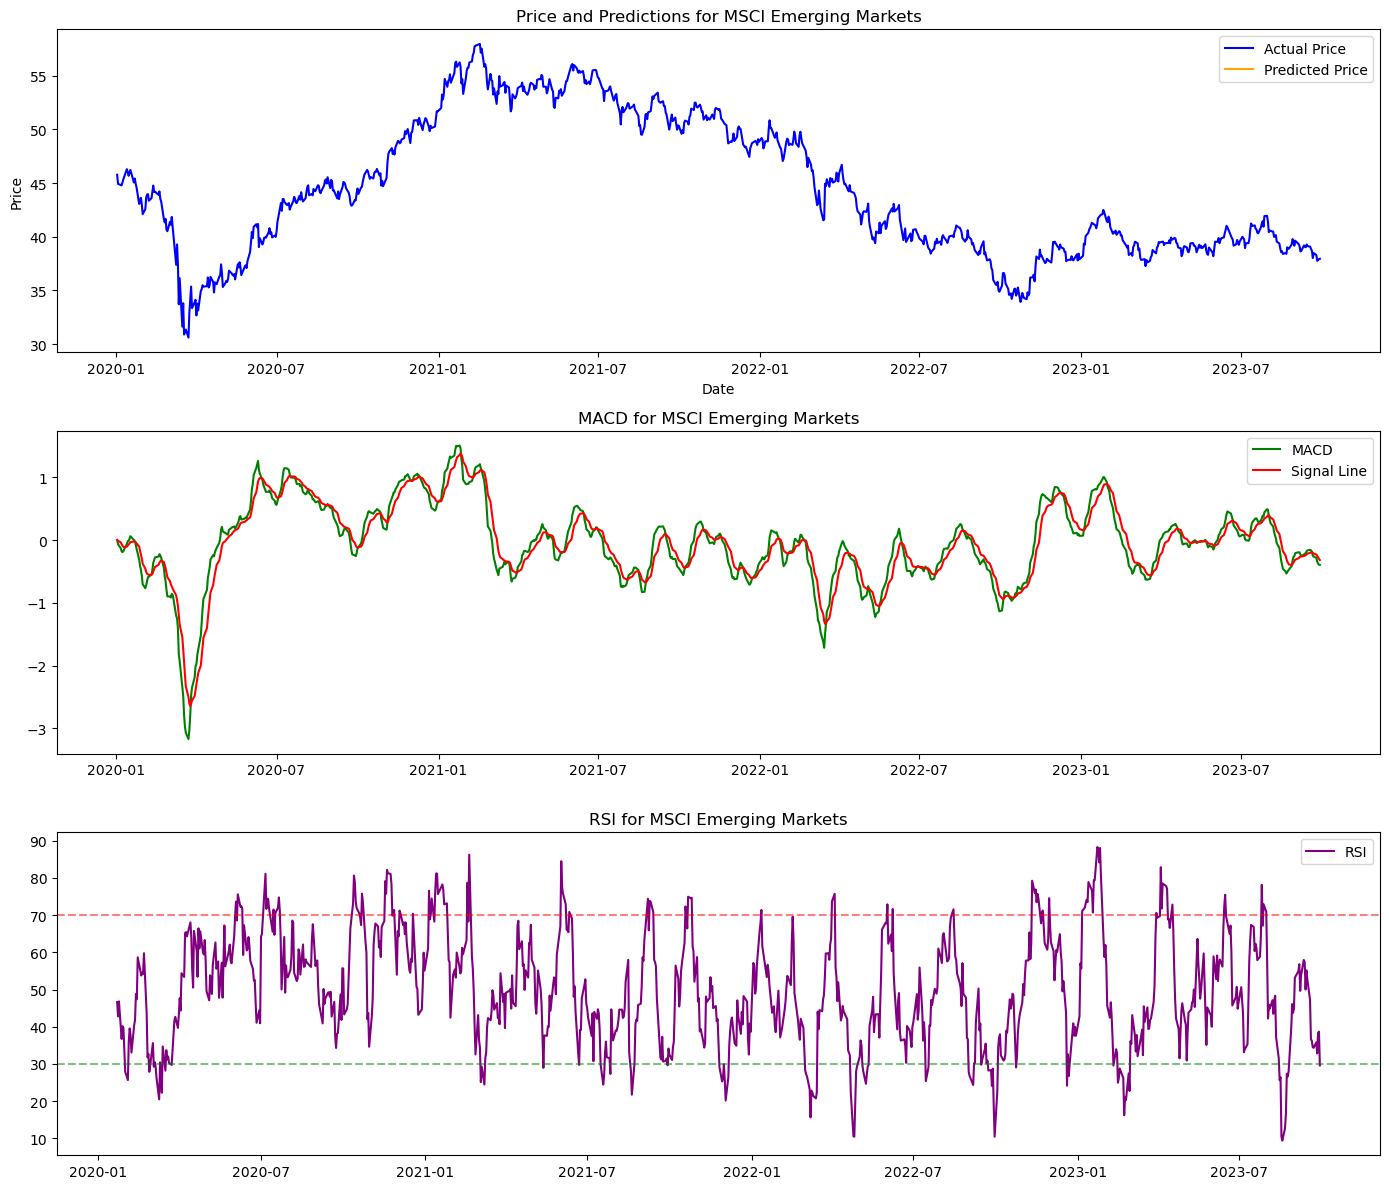

c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


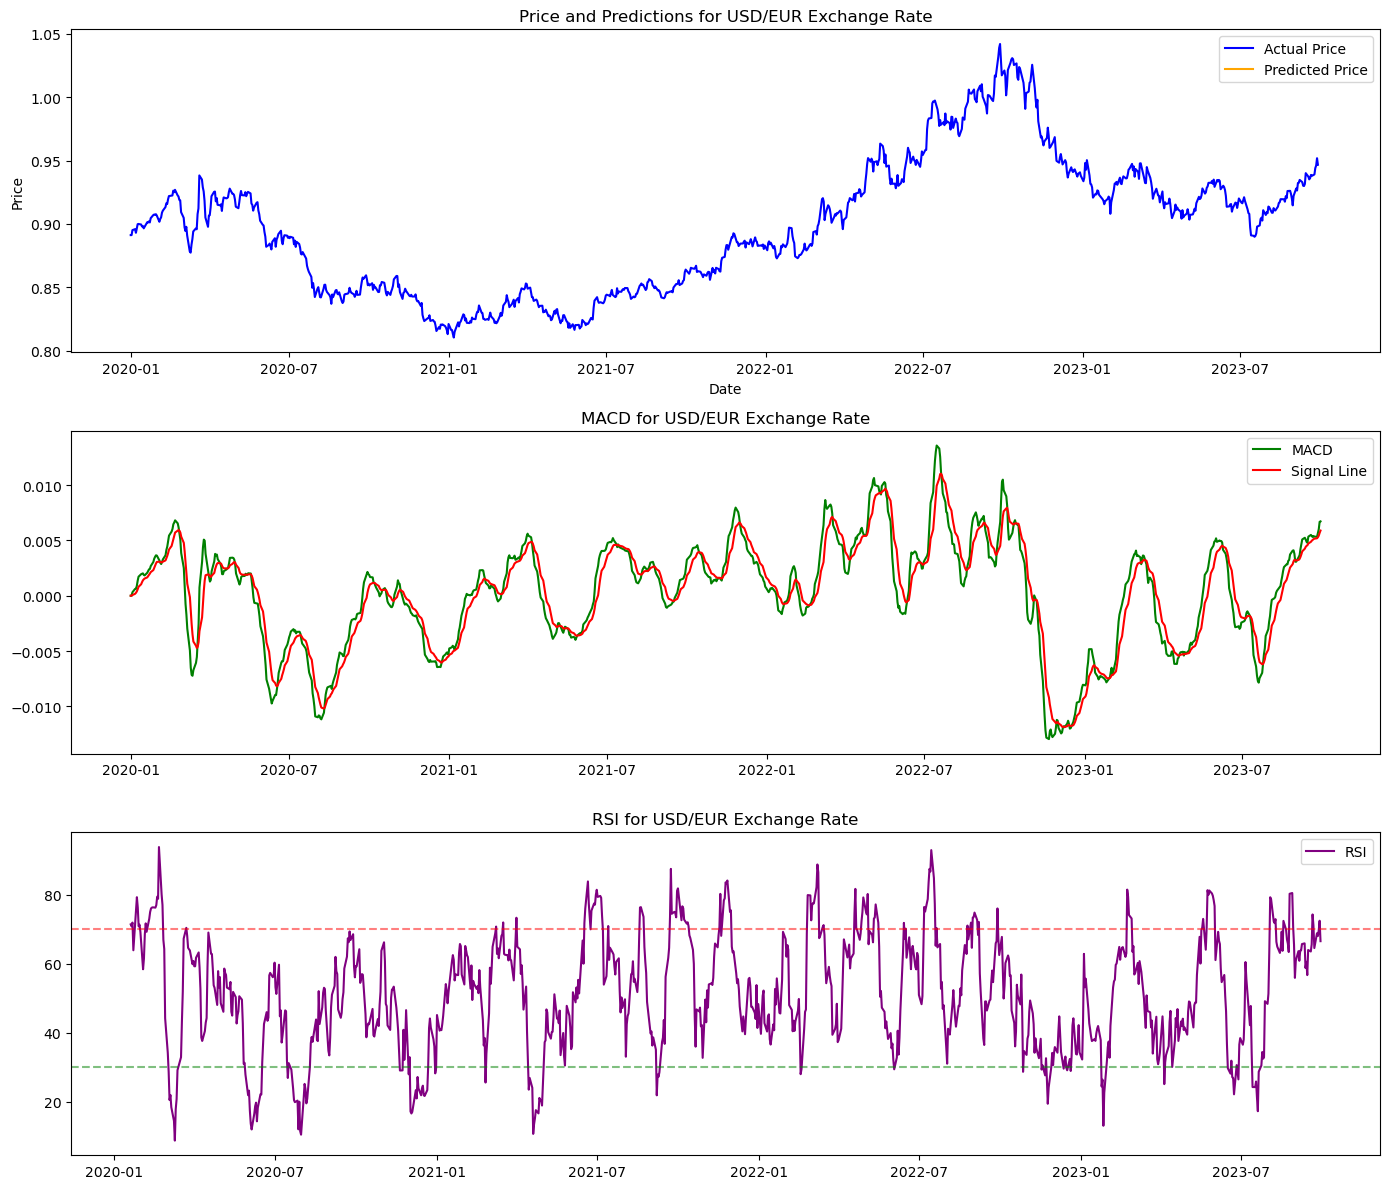

Team D: Crude Oil Future: nan, Microsoft: nan, MSCI World: nan, MSCI Emerging Markets: nan, USD/EUR Exchange Rate: 0.95


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA

# Define the symbols
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to fetch historical prices
def fetch_data(symbol):
    try:
        data = yf.download(symbol, start="2020-01-01", end="2023-09-30", interval="1d")
        return data[['Close']]
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Function to predict future prices
def predict_future(symbol, data, steps=1):
    model = ARIMA(data['Close'], order=(5, 1, 0))
    model_fit = model.fit()  # Removed disp=0
    forecast = model_fit.forecast(steps=steps)

    # Create a date range for the future predictions
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='B')
    
    # Return a Series with forecasted values
    return pd.Series(forecast, index=future_dates)

# Function to calculate MACD
def calculate_macd(data):
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Dictionary to hold data for each symbol
data_dict = {}

# Fetch data for each symbol
for symbol in symbols.keys():
    data = fetch_data(symbol)
    if data is not None:
        data_dict[symbol] = data

# Predictions and indicators storage
predictions = {}
for symbol, data in data_dict.items():
    # Predict future price for the next business day
    predictions[symbol] = predict_future(symbol, data, steps=1)

    # Calculate MACD and RSI
    macd, signal = calculate_macd(data)
    rsi = calculate_rsi(data)

    # Plotting
    plt.figure(figsize=(14, 12))

    # Price and Predictions
    plt.subplot(3, 1, 1)
    plt.plot(data['Close'], label='Actual Price', color='blue')
    plt.plot(predictions[symbol].index, predictions[symbol].values, label='Predicted Price', color='orange')
    plt.title(f'Price and Predictions for {symbols[symbol]}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # MACD and Signal
    plt.subplot(3, 1, 2)
    plt.plot(macd, label='MACD', color='green')
    plt.plot(signal, label='Signal Line', color='red')
    plt.title(f'MACD for {symbols[symbol]}')
    plt.legend()

    # RSI
    plt.subplot(3, 1, 3)
    plt.plot(rsi, label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')
    plt.title(f'RSI for {symbols[symbol]}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Output predictions for email
email_content = "Team D: "
for symbol in symbols.keys():
    email_content += f"{symbols[symbol]}: {predictions[symbol].values[-1]:.2f}, "

# Print email content
print(email_content[:-2])  # Remove trailing comma and space


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming we have the actual closing prices for the predicted period
# We need to ensure that the index matches between predicted and actual values
actual_prices = data['Close'].loc[predicted_values.index]

# Calculate MAE and RMSE
mae = mean_absolute_error(actual_prices, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_values))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


AttributeError: 'numpy.float64' object has no attribute 'index'

[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availa

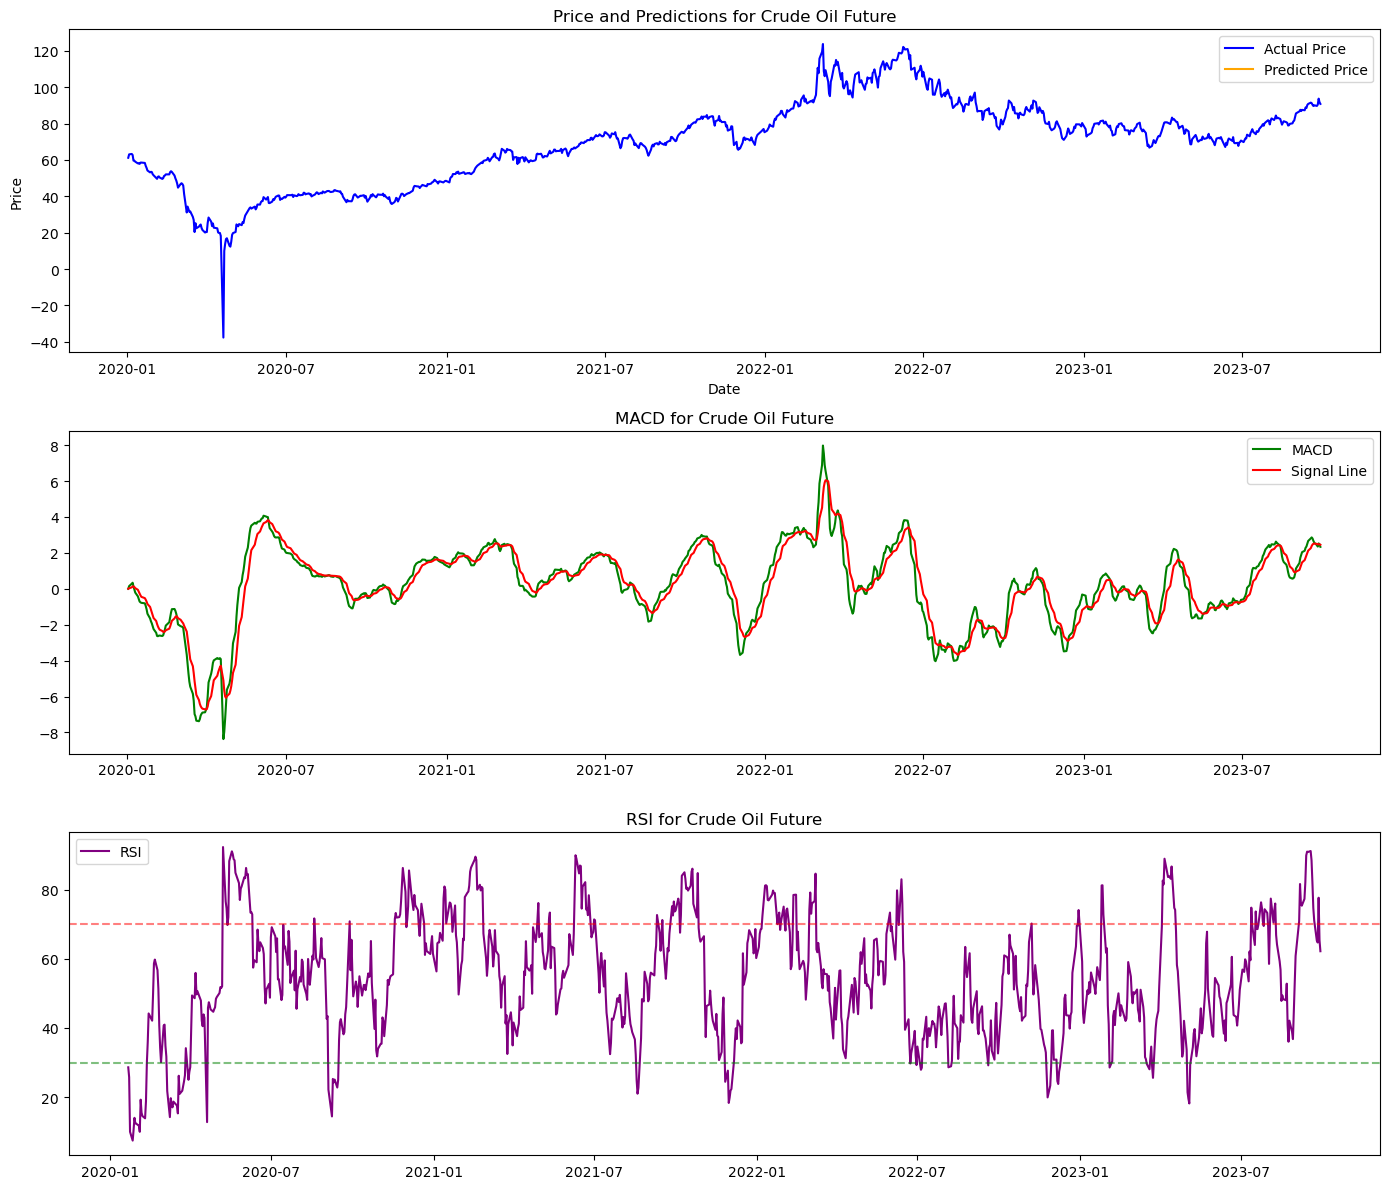

[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availa

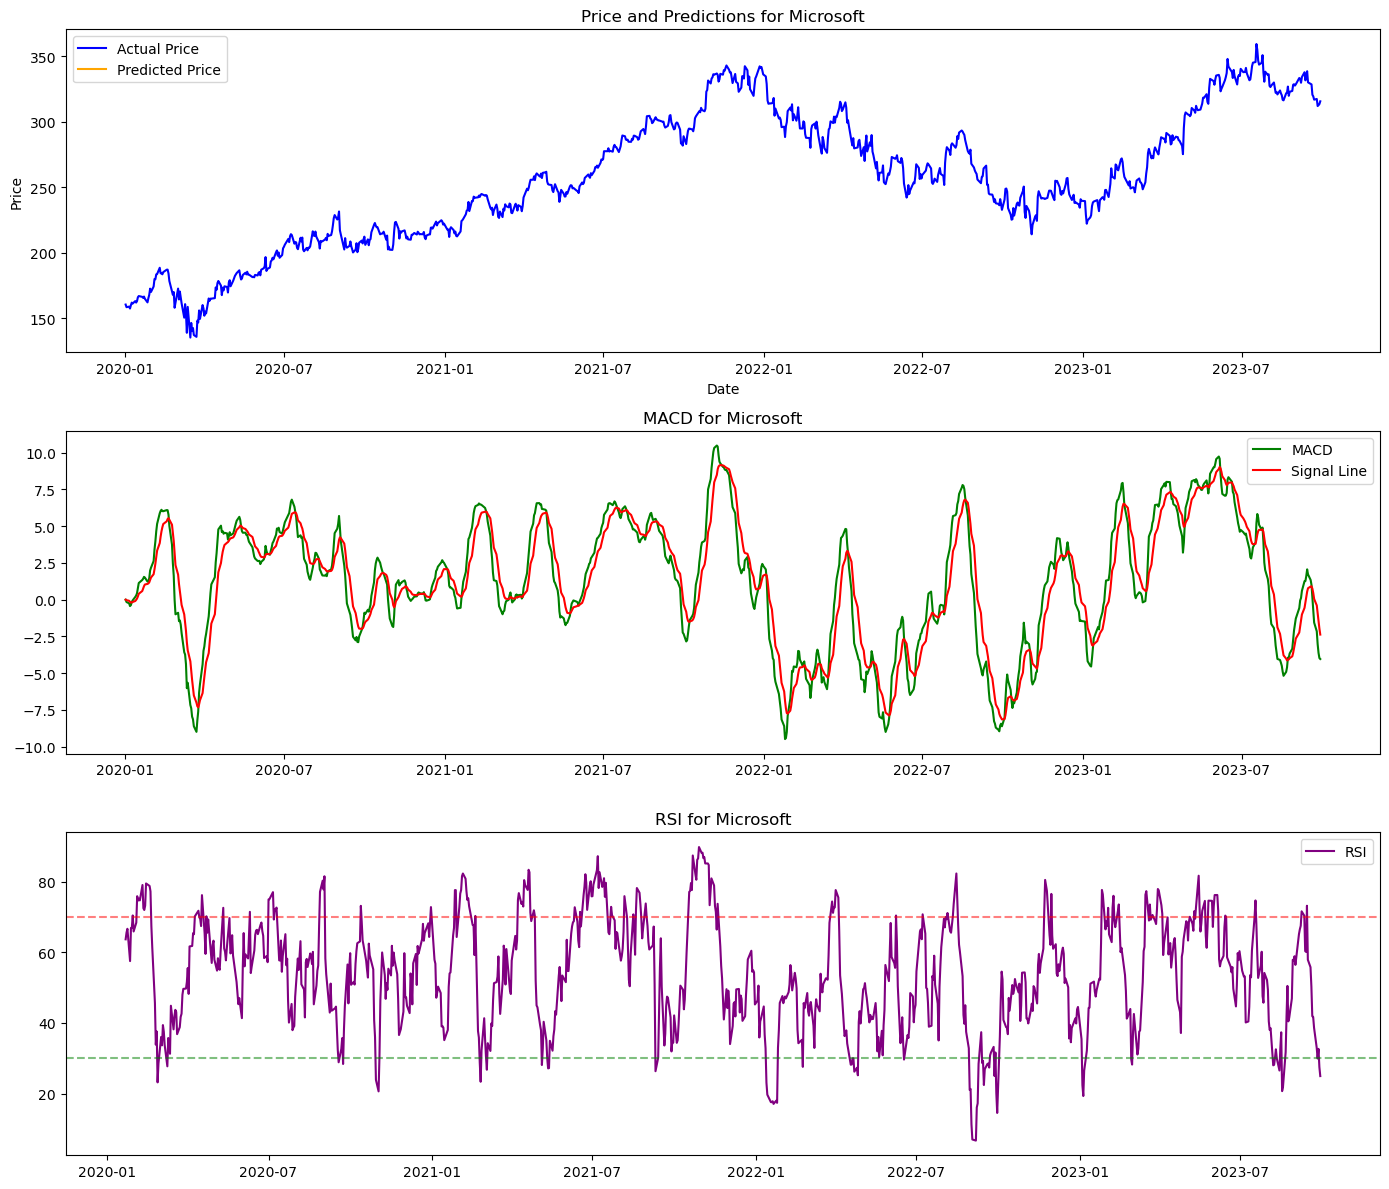

[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availa

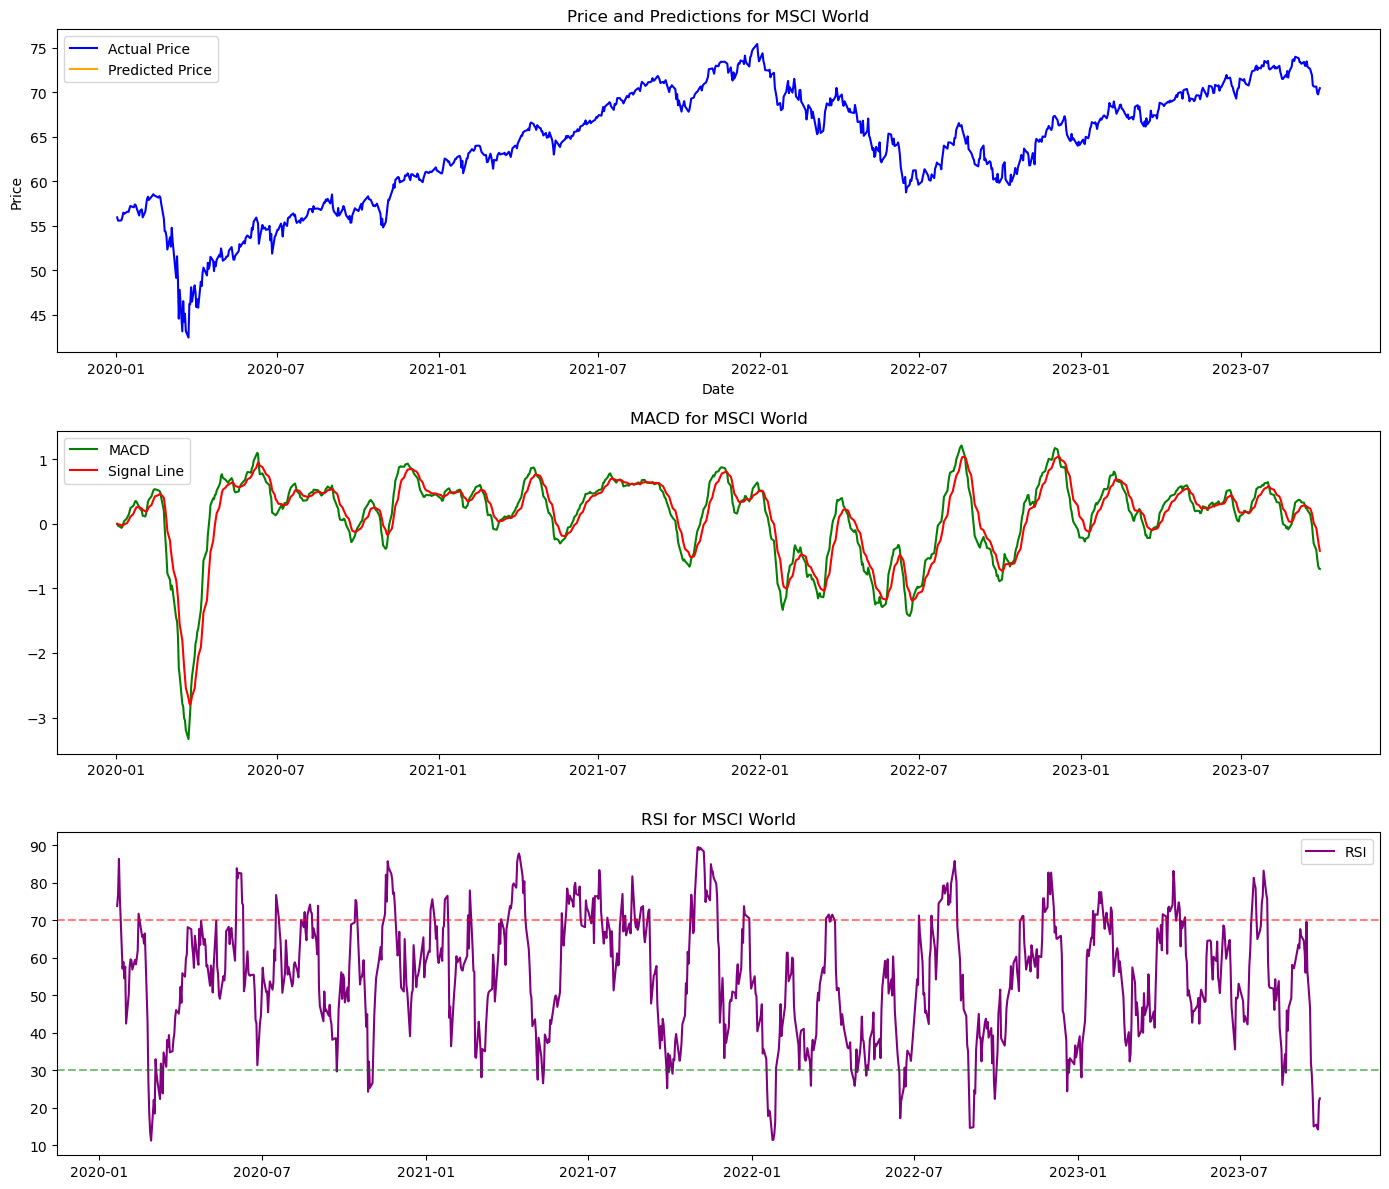

[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availa

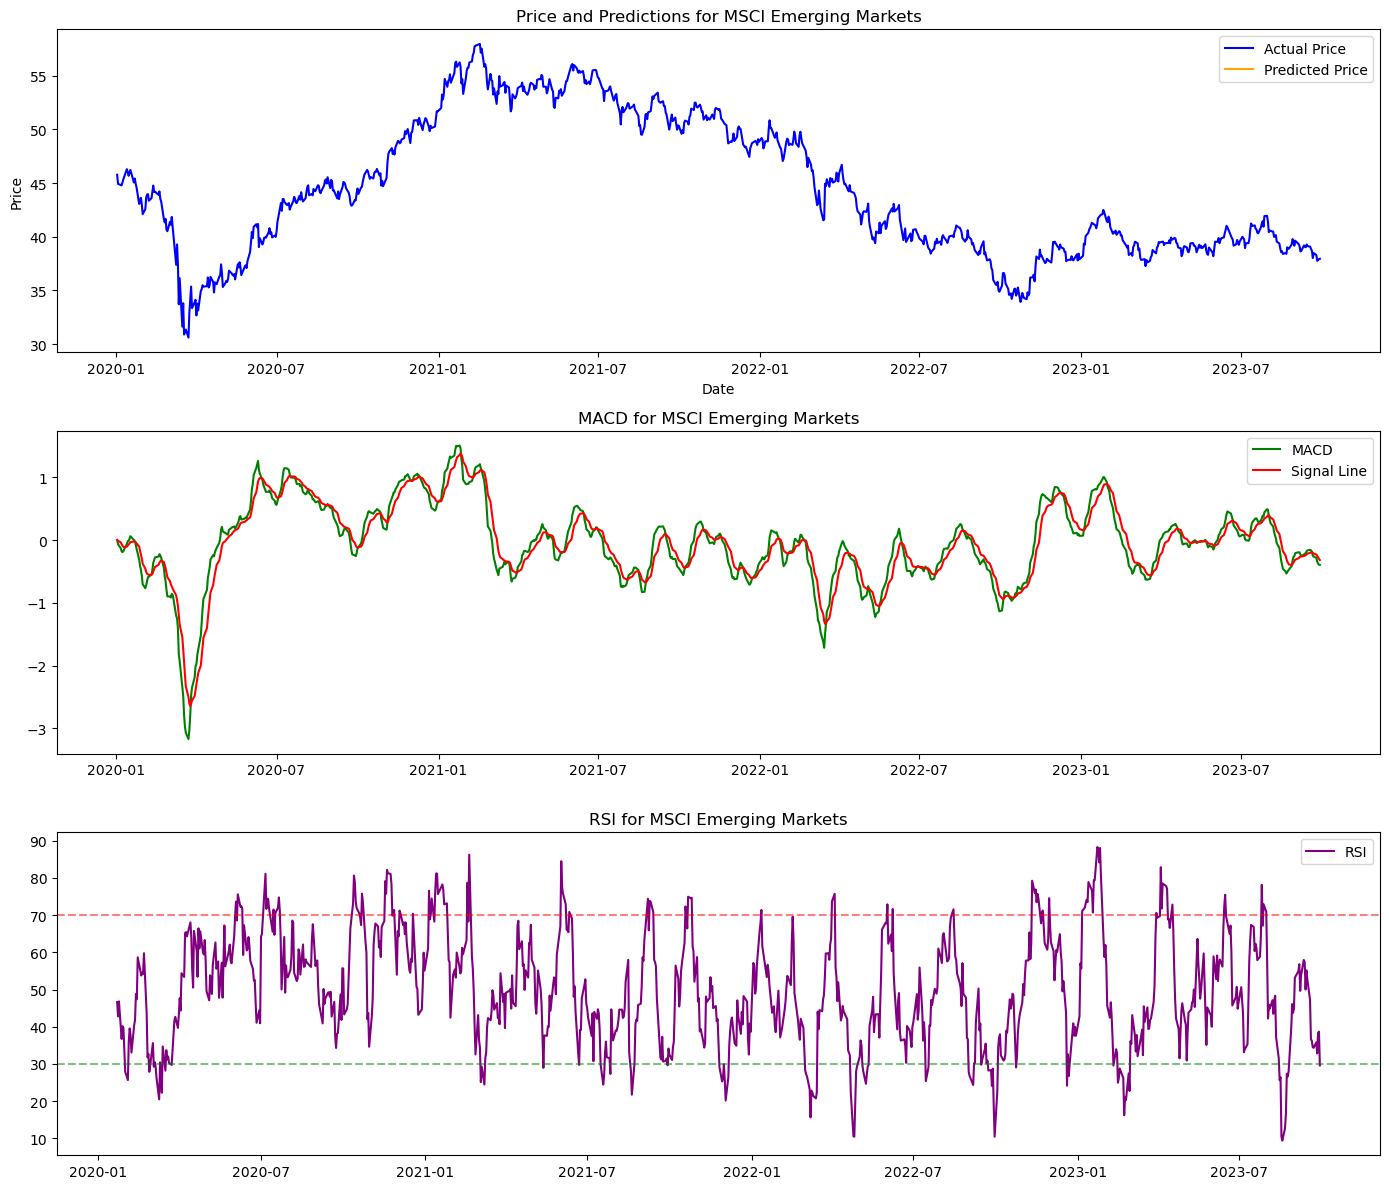

[*********************100%***********************]  1 of 1 completed
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


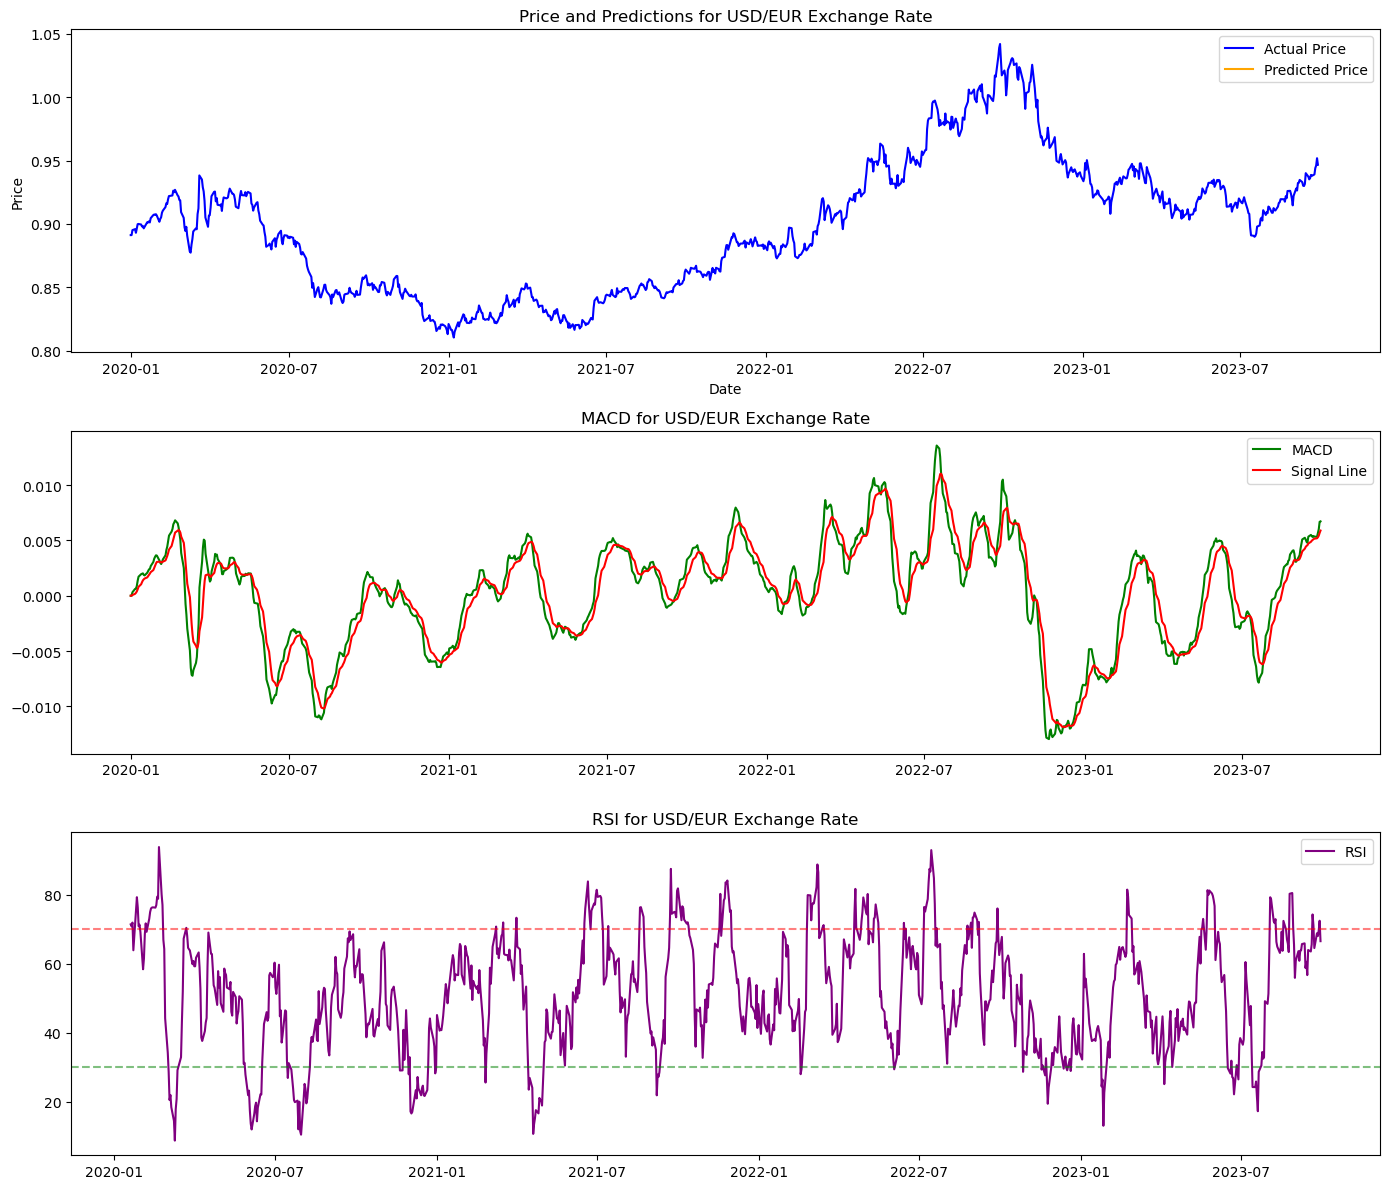

Team D: Crude Oil Future: nan, Microsoft: nan, MSCI World: nan, MSCI Emerging Markets: nan, USD/EUR Exchange Rate: 0.95


ValueError: Input contains NaN.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the symbols
symbols = {
    "CL=F": "Crude Oil Future",
    "MSFT": "Microsoft",
    "XWD.TO": "MSCI World",
    "EEM": "MSCI Emerging Markets",
    "EUR=X": "USD/EUR Exchange Rate"
}

# Function to fetch historical prices
def fetch_data(symbol):
    try:
        data = yf.download(symbol, start="2020-01-01", end="2023-09-30", interval="1d")
        return data[['Close']]
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Function to predict future prices
def predict_future(symbol, data, steps=1):
    model = ARIMA(data['Close'], order=(5, 1, 0))
    model_fit = model.fit()  # Removed disp=0
    forecast = model_fit.forecast(steps=steps)

    # Create a date range for the future predictions
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='B')
    
    # Return a Series with forecasted values
    return pd.Series(forecast, index=future_dates)

# Function to calculate MACD
def calculate_macd(data):
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Dictionary to hold data for each symbol
data_dict = {}
predictions = {}

# Fetch data for each symbol
for symbol in symbols.keys():
    data = fetch_data(symbol)
    if data is not None:
        data_dict[symbol] = data
        # Predict future price for the next business day
        predictions[symbol] = predict_future(symbol, data, steps=1)

        # Calculate MACD and RSI
        macd, signal = calculate_macd(data)
        rsi = calculate_rsi(data)

        # Plotting
        plt.figure(figsize=(14, 12))

        # Price and Predictions
        plt.subplot(3, 1, 1)
        plt.plot(data['Close'], label='Actual Price', color='blue')
        plt.plot(predictions[symbol].index, predictions[symbol].values, label='Predicted Price', color='orange')
        plt.title(f'Price and Predictions for {symbols[symbol]}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()

        # MACD and Signal
        plt.subplot(3, 1, 2)
        plt.plot(macd, label='MACD', color='green')
        plt.plot(signal, label='Signal Line', color='red')
        plt.title(f'MACD for {symbols[symbol]}')
        plt.legend()

        # RSI
        plt.subplot(3, 1, 3)
        plt.plot(rsi, label='RSI', color='purple')
        plt.axhline(70, linestyle='--', alpha=0.5, color='red')
        plt.axhline(30, linestyle='--', alpha=0.5, color='green')
        plt.title(f'RSI for {symbols[symbol]}')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Output predictions for email
email_content = "Team D: "
for symbol in symbols.keys():
    email_content += f"{symbols[symbol]}: {predictions[symbol].values[-1]:.2f}, "

# Print email content
print(email_content[:-2])  # Remove trailing comma and space

# Performance Evaluation
for symbol in symbols.keys():
    data = data_dict[symbol]
    predicted_values = predictions[symbol]

    # To compare, assume the actual prices would be the last known prices
    actual_prices = data['Close'].iloc[-1]

    # Calculate MAE and RMSE
    mae = mean_absolute_error([actual_prices], predicted_values)
    rmse = np.sqrt(mean_squared_error([actual_prices], predicted_values))

    print(f"Performance Metrics for {symbols[symbol]}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}\n")


In [46]:
# Performance Evaluation
for symbol in symbols.keys():
    data = data_dict[symbol]
    predicted_values = predictions[symbol]

    # To compare, assume the actual prices would be the last known prices
    actual_prices = data['Close'].iloc[-1]

    # Convert actual prices to a Series for compatibility
    actual_prices_series = pd.Series([actual_prices], index=predicted_values.index)

    # Check for NaN values in predictions
    if predicted_values.isnull().any() or actual_prices_series.isnull().any():
        print(f"Warning: NaN values found in predictions or actual prices for {symbols[symbol]}! Skipping this symbol.")
        continue  # Skip to the next symbol if NaN values are present

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual_prices_series, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_prices_series, predicted_values))

    print(f"Performance Metrics for {symbols[symbol]}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}\n")


Performance Metrics for USD/EUR Exchange Rate:
Mean Absolute Error (MAE): 0.00
Root Mean Square Error (RMSE): 0.00



c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\sklearn\utils\_array_api.py:745: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
c:\Users\NIMISHA\.conda\envs\IPDA_01\Lib\site-packages\sklearn\utils\_array_api.py:745: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


In [47]:
# Performance Evaluation
for symbol in symbols.keys():
    data = data_dict[symbol]
    predicted_values = predictions[symbol]

    # Print out predicted values for debugging
    print(f"Predicted values for {symbols[symbol]}: {predicted_values}")

    # Check if predicted_values is a Series
    if not isinstance(predicted_values, pd.Series):
        print(f"Warning: Predicted values for {symbols[symbol]} is not a Series!")
        continue

    # To compare, assume the actual prices would be the last known prices
    actual_prices = float(data['Close'].iloc[-1])  # Ensure it's a float

    # Convert actual prices to a Series for compatibility
    actual_prices_series = pd.Series([actual_prices], index=predicted_values.index)

    # Check for NaN values in predictions and actual prices
    if predicted_values.isnull().any() or actual_prices_series.isnull().any():
        print(f"Warning: NaN values found in predictions or actual prices for {symbols[symbol]}! Skipping this symbol.")
        continue  # Skip to the next symbol if NaN values are present

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual_prices_series, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_prices_series, predicted_values))

    print(f"Performance Metrics for {symbols[symbol]}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}\n")


Predicted values for Crude Oil Future: 2023-10-02 00:00:00+00:00   NaN
Freq: B, dtype: float64
Predicted values for Microsoft: 2023-10-02 00:00:00+00:00   NaN
Freq: B, dtype: float64
Predicted values for MSCI World: 2023-10-02 00:00:00+00:00   NaN
Freq: B, dtype: float64
Predicted values for MSCI Emerging Markets: 2023-10-02 00:00:00+00:00   NaN
Freq: B, dtype: float64
Predicted values for USD/EUR Exchange Rate: 2023-10-02 00:00:00+00:00    0.946402
Freq: B, dtype: float64
Performance Metrics for USD/EUR Exchange Rate:
Mean Absolute Error (MAE): 0.00
Root Mean Square Error (RMSE): 0.00



C:\Users\NIMISHA\AppData\Local\Temp\ipykernel_5932\3050897970.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  actual_prices = float(data['Close'].iloc[-1])  # Ensure it's a float
